# Objective
Through this project, I am going to build a machine learning model that
predicts whether or not a customer will respond to a purchase offer sent by Starbucks through their mobile app. And, to determine the possible
level of response or user actions like offer received, offer viewed, transaction, offer
completed etc. Such that, the company can send each offer to the respective targeted audience where it can get the possible maximum reponse as predicted. I will be using the dataset 'Starbucks app customer rewards program data' which contains simulated data that mimics
customer behaviour on the Starbucks rewards mobile app for this machine learning problem.

### Possible User Actions or Responses:
1. **offer recieved** - Indicates that the offer has reached the customer.
2. **offer viewed** - Indicates that the customer has viewed the offer.
3. **transaction** - Indicates that the customer has performed a transaction but were not eligible for the offer.
4. **offer completed** - Indicates that the customer has performed a transaction using the sent offer.
5. **green flag** - Indicates that the customer has performed a transaction without using the offer, eventhough they were eligible for the offer.(From a business perspective, it's a good sign. We could restrict senting offers to those people in the future.)

# Problem Statement
Predict the purchace offer to which a possible higher level of response or user actions like ‘offer
received’, ‘offer viewed’, ‘transaction’, ‘offer completed’, ‘green flag’ (in order from the
top priority to low) can be achieved based on the demographic attributes of the
customer and other attributes of the companies purchase offers. If the customer response is not the
maximum i.e. ‘green flag’ then execute the preset procedures to elevate the response
from its current value to the next higher possible value.

In [1]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('../input/starbucks-app-customer-reward-program-data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../input/starbucks-app-customer-reward-program-data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../input/starbucks-app-customer-reward-program-data/transcript.json', orient='records', lines=True)

# Dataset Formation

First of all, let's discuss what is so strange about our dataset and how to handle it. The Starbucks dataset exists as three separate files i.e. portfolio.json (), profile.json and transcript.json. So, we have to identify a way to combine the required data variables from these data files to form a single dataset.  


To start with, let's check whether the unique values in profile equals unique values in transcript to make sure that there are no additional customer records in the profile which are not in transcript.

In [2]:
if(pd.unique(transcript['person']).shape == pd.unique(profile['id']).shape):
    print("Success")
else:
    print("Failure")

Success


In [3]:
customer_ids = pd.unique(transcript['person'])

#encode customer ids which is in string format to integers
customer_ids_dict = pd.Series(customer_ids).to_dict()
customer_ids_dict = dict([(value, key) for key, value in customer_ids_dict.items()]) 
itr = iter(customer_ids_dict.items())
lst = [next(itr) for i in range(10)]
print(lst)

[('78afa995795e4d85b5d9ceeca43f5fef', 0), ('a03223e636434f42ac4c3df47e8bac43', 1), ('e2127556f4f64592b11af22de27a7932', 2), ('8ec6ce2a7e7949b1bf142def7d0e0586', 3), ('68617ca6246f4fbc85e91a2a49552598', 4), ('389bc3fa690240e798340f5a15918d5c', 5), ('c4863c7985cf408faee930f111475da3', 6), ('2eeac8d8feae4a8cad5a6af0499a211d', 7), ('aa4862eba776480b8bb9c68455b8c2e1', 8), ('31dda685af34476cad5bc968bdb01c53', 9)]


In [4]:
#map encoded customer ids to ids in transcrpt and profile dataframes
transcript['person'] = transcript['person'].map(customer_ids_dict)
profile['id'] = profile['id'].map(customer_ids_dict)

In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,14980,20170212,NaN
1,F,55,12990,20170715,112000.0
2,None,118,14643,20180712,NaN
3,F,75,0,20170509,100000.0
4,None,118,1,20170804,NaN


In [6]:
transcript.head()

,person,event,value,time
0,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
#sort transcript and profile dataframe rows based on customer ids
sorted_transcript = transcript.sort_values('person', axis=0, ascending=True, inplace=False, kind='quicksort')
sorted_profile = profile.sort_values('id', axis=0, ascending=True, inplace=False, kind='quicksort')

In [9]:
#reset index to the current form i.e. after sort
sorted_transcript.reset_index(inplace=True)

In [10]:
#drop the column index as it is not required
sorted_transcript = sorted_transcript.drop(labels=['index'], axis=1)

In [11]:
sorted_transcript.head()

,person,event,value,time
0,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582
2,0,transaction,{'amount': 19.67},222
3,0,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
4,0,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216


In [12]:
#reset index to the current form i.e. after sort
sorted_profile.reset_index(inplace=True)

In [13]:
#drop the column index as it is not required
sorted_profile = sorted_profile.drop(labels=['index'], axis=1)

In [14]:
sorted_profile.head()

,gender,age,id,became_member_on,income
0,F,75,0,20170509,100000.0
1,None,118,1,20170804,NaN
2,M,68,2,20180426,70000.0
3,None,118,3,20170925,NaN
4,None,118,4,20171002,NaN


In [15]:
#find frequency of each customer ids in the transcript dataframe
customer_ids_frequency = sorted_transcript['person'].value_counts(sort=False)

In [16]:
#to perform repeatation of records, the repeat count is to be added along each corresponding rows
sorted_profile = pd.concat([sorted_profile, customer_ids_frequency], axis=1)

In [17]:
sorted_profile.head()

,gender,age,id,became_member_on,income,person
0,F,75,0,20170509,100000.0,18
1,None,118,1,20170804,NaN,11
2,M,68,2,20180426,70000.0,12
3,None,118,3,20170925,NaN,10
4,None,118,4,20171002,NaN,11


In [18]:
#duplicate each rows in sorted profile based on the frequency of each customer ids in transcript
profile_with_duplicate_rows = sorted_profile.reindex(sorted_profile.index.repeat(sorted_profile.person))

In [19]:
#reset index to the current form i.e. after sort
profile_with_duplicate_rows.reset_index(inplace=True)

In [20]:
#drop the columns index and person as they aren't anymore required
profile_with_duplicate_rows = profile_with_duplicate_rows.drop(labels=['index', 'person'], axis=1)

In [21]:
profile_with_duplicate_rows.head()

,gender,age,id,became_member_on,income
0,F,75,0,20170509,100000.0
1,F,75,0,20170509,100000.0
2,F,75,0,20170509,100000.0
3,F,75,0,20170509,100000.0
4,F,75,0,20170509,100000.0


In [22]:
#concatenate sorted transcript and profile with duplicate rows
transcript_profile_concatenated = pd.concat([sorted_transcript, profile_with_duplicate_rows], axis=1)

In [23]:
transcript_profile_concatenated.tail()

,person,event,value,time,gender,age,id,became_member_on,income
306529,16997,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN
306530,16997,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN
306531,16998,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306532,16998,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306533,16999,transaction,{'amount': 0.35000000000000003},582,None,118,16999,20170801,NaN


In [24]:
#verify whether customer ids from transcript and profile are aligned correctly
(transcript_profile_concatenated['person'] == transcript_profile_concatenated['id']).all()

True

In [25]:
#drop the column person as it is not anymore required
transcript_profile_concatenated = transcript_profile_concatenated.drop(labels=['person'], axis=1)

In [26]:
transcript_profile_concatenated

,event,value,time,gender,age,id,became_member_on,income
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0
...,...,...,...,...,...,...,...,...
306529,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN
306530,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN
306531,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306532,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0


In [27]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [28]:
#encode offer ids in portfolio dataframe from string format to integer
offer_ids = portfolio['id'].unique()
offer_ids_dict = pd.Series(offer_ids).to_dict()
offer_ids_dict = dict([(value, key) for key, value in offer_ids_dict.items()]) 

In [29]:
offer_ids_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [30]:
#map ids in portfolio to encoded offer ids
portfolio['id'] = portfolio['id'].map(offer_ids_dict)

In [31]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,0
1,10,"[web, email, mobile, social]",10,5,bogo,1
2,0,"[web, email, mobile]",0,4,informational,2
3,5,"[web, email, mobile]",5,7,bogo,3
4,5,"[web, email]",20,10,discount,4
5,3,"[web, email, mobile, social]",7,7,discount,5
6,2,"[web, email, mobile, social]",10,10,discount,6
7,0,"[email, mobile, social]",0,3,informational,7
8,5,"[web, email, mobile, social]",5,5,bogo,8
9,2,"[web, email, mobile]",10,7,discount,9


In [32]:
#inspect random rows for any error
fraction_of_rows = transcript_profile_concatenated.sample(frac=0.003)
fraction_of_rows

,event,value,time,gender,age,id,became_member_on,income
72582,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},432,None,118,3850,20180215,NaN
283283,transaction,{'amount': 12.03},444,M,40,15327,20180110,59000.0
60781,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},336,F,56,3232,20160602,104000.0
300958,transaction,{'amount': 40.23},546,M,69,16516,20160630,92000.0
70865,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},576,F,23,3760,20160221,35000.0
...,...,...,...,...,...,...,...,...
40509,transaction,{'amount': 2.63},96,M,55,2147,20161225,62000.0
146196,transaction,{'amount': 14.44},504,M,44,7763,20151021,39000.0
214727,transaction,{'amount': 17.65},414,M,39,11415,20151028,69000.0
198125,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,M,18,10531,20180725,45000.0


In [33]:
transcript_profile_concatenated.tail()

,event,value,time,gender,age,id,became_member_on,income
306529,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN
306530,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN
306531,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306532,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306533,transaction,{'amount': 0.35000000000000003},582,None,118,16999,20170801,NaN


In [34]:
transcript_profile_concatenated.head()

,event,value,time,gender,age,id,became_member_on,income
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0


In [35]:
#get a series of offer ids from the concatenated dataframe
offer_id_series = transcript_profile_concatenated['value']

In [36]:
def get_dict_values(x):
    """Finds the first value of the key from a single key-value pair.
    
    Args:
        x (dictionary object): Expects a dictionary key-value pair.
    
    Returns:
        value: First value from the passed key-value pair.
        
    """
    key = list(x.keys())[0]
    value = x[key]
    return value

In [37]:
#map every element of offer id series to the function get_dict_values(). This step is essential as every 
#element in offer id series exists as a dictionary key-value pair.
offer_id_series = pd.DataFrame(offer_id_series).applymap(lambda x: get_dict_values(x))

In [38]:
offer_id_series.head()

,value
0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,f19421c1d4aa40978ebb69ca19b0e20d
2,19.67
3,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5a8bc65990b245e5a138643cd4eb9837


In [39]:
def encode_offer_id(x):
    """Encode the given string into a integer based on the dictionary offer_ids_dict.
    
    Args:
        x (str or int): Expects an integer or string value from offer_id_series.
    
    Return:
        10 or offer_id_dict[x]: 10 is returned if the passed argument is integer and if the argument is a string,
                                the value for the key, x in offer_id_dict is returned.
    """
    if(type(x) is str):
        return offer_ids_dict[x]
    else:
        return 10

In [40]:
#map offer id series to the function encode_offer_id()
encoded_offer_id_series = offer_id_series.applymap(lambda x: encode_offer_id(x))

In [41]:
encoded_offer_id_series.head()

,value
0,3
1,8
2,10
3,3
4,7


In [42]:
#add the column, offer_id with values from encoded_offer_id_series dataframe to the dataframe 
#transcript_profile_portfolio_concatenated
transcript_profile_portfolio_concatenated = transcript_profile_concatenated
transcript_profile_portfolio_concatenated['offer_id'] = encoded_offer_id_series['value']

In [43]:
transcript_profile_portfolio_concatenated.head(10)

,event,value,time,gender,age,id,became_member_on,income,offer_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7
5,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,75,0,20170509,100000.0,7
6,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,F,75,0,20170509,100000.0,8
7,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,510,F,75,0,20170509,100000.0,8
8,transaction,{'amount': 23.93},378,F,75,0,20170509,100000.0,10
9,transaction,{'amount': 19.89},132,F,75,0,20170509,100000.0,10


In [44]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,0
1,10,"[web, email, mobile, social]",10,5,bogo,1
2,0,"[web, email, mobile]",0,4,informational,2
3,5,"[web, email, mobile]",5,7,bogo,3
4,5,"[web, email]",20,10,discount,4
5,3,"[web, email, mobile, social]",7,7,discount,5
6,2,"[web, email, mobile, social]",10,10,discount,6
7,0,"[email, mobile, social]",0,3,informational,7
8,5,"[web, email, mobile, social]",5,5,bogo,8
9,2,"[web, email, mobile]",10,7,discount,9


In [45]:
#convert the columns reward, difficulty and duration of portfolio dataframe into dictionaries 
portfolio_reward_dict = portfolio['reward'].to_dict()
portfolio_difficulty_dict = portfolio['difficulty'].to_dict()
portfolio_duration_dict = portfolio['duration'].to_dict()

In [46]:
def add_column(column_name, column_dict):
    """To add new column to the transcript_profile_portfolio_concatenated dataframe.
    
    Args:
        column_name (str): Name of the column to be added.
        column_dict (dict): Dictionary with column name as the key and values as data to the column.
        
    Return:
        None
    """
    transcript_profile_portfolio_concatenated[column_name] = transcript_profile_portfolio_concatenated['offer_id'].map(column_dict)

In [47]:
add_column('reward', portfolio_reward_dict)
add_column('difficulty', portfolio_difficulty_dict)
add_column('duration', portfolio_duration_dict)

In [48]:
transcript_profile_portfolio_concatenated.head()

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10,NaN,NaN,NaN
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0


In [49]:
#inspect random rows to find the basic structure of the column became_member_on
transcript_profile_portfolio_concatenated['became_member_on'].sample(frac=.003)

168495    20130906
300428    20180516
124541    20170301
140138    20150929
41190     20170623
            ...   
105376    20170113
166552    20170507
114920    20170220
30095     20160919
174130    20160715
Name: became_member_on, Length: 920, dtype: int64

In [50]:
def find_month(x):
    """To find month from the passed numerical date of the format YYYYMMDD.
    
    Args:
        x (int): Date which is of the form YYYYMMDD.
        
    Return:
        x%100 (int): MM of the date is returned.
    """
    x = x/100
    x = int(x)
    return x%100

In [51]:
#map the column reg_month to the find_month() function
transcript_profile_portfolio_concatenated['reg_month'] = transcript_profile_portfolio_concatenated['became_member_on'].map(lambda x: find_month(x))

In [52]:
transcript_profile_portfolio_concatenated.head()

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration,reg_month
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10,NaN,NaN,NaN,5
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5


In [53]:
#encode event ids in string format to integer
event_ids = transcript_profile_portfolio_concatenated['event'].unique()
event_ids_dict = pd.Series(event_ids).to_dict()
event_ids_dict = dict([(value, key) for key, value in event_ids_dict.items()]) 

In [54]:
#add one more event to the dictionary, green flag which indicates the customer does not view the 
#offer but completes the offer. Thus, it's a green flag in a business perspective.
event_ids_dict['green flag'] = 4
event_ids_dict

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3,
 'green flag': 4}

In [55]:
#map event_ids to the encoded event ids
transcript_profile_portfolio_concatenated['event_id'] = transcript_profile_portfolio_concatenated['event'].map(event_ids_dict)

In [56]:
transcript_profile_portfolio_concatenated

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration,reg_month,event_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5,1
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10,NaN,NaN,NaN,5,2
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,1
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN,1,10.0,10.0,5.0,9,1
306530,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN,1,10.0,10.0,5.0,9,0
306531,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0,1,10.0,10.0,5.0,10,0
306532,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0,1,10.0,10.0,5.0,10,1


In [57]:
#sort the transcript_profile_portfolio_concatenated dataframe based on id, offer_id and event_id for easy feature engineering later
sorted_dataset = transcript_profile_portfolio_concatenated.sort_values(by=['id', 'offer_id', 'event_id'], ascending=[True, True, False])

In [58]:
sorted_dataset.head(20)

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration,reg_month,event_id
11,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,510,F,75,0,20170509,100000.0,0,10.0,10.0,7.0,5,3
12,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,F,75,0,20170509,100000.0,0,10.0,10.0,7.0,5,1
13,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,F,75,0,20170509,100000.0,0,10.0,10.0,7.0,5,0
17,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,3
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,1
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5,1
5,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5,0
7,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,510,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5,3
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5,1


In [59]:
#reset index to the current form i.e. after sort
sorted_dataset.reset_index(inplace=True)

In [60]:
#form the dataset with only columns that are required for later cases
columns=['id', 'offer_id', 'event_id', 'gender', 'age', 'income', 'reward', 'difficulty', 'reg_month']
dataset = sorted_dataset[columns]

In [61]:
dataset.shape

(306534, 9)

In [62]:
#dataframe for storing dataframe from dataset after filtering out unwanted rows
dataset_after_filter = pd.DataFrame()

In [63]:
def aggregate(x):
    """To find sum of the current element and all the previous elements and storing it in the current position.
       This is to be done from start of the list to the end.
       
    Args:
        x (list): List of integer values.
        
    Returns:
        x (list): Function will be performed to every element from start to end. Last element will be removed 
        from the list before returning.
    
    """
    for i in range(1, len(x)):
        x[i] = x[i] + x[i-1]
    x.pop()
    return x

In [64]:
import warnings
warnings.simplefilter('ignore')

In [65]:
%%time

#find and select only the records from the dataset for which the event performed by the customer for each offers
#send to them is the highest. And, change the event id of those selected records with event id = 1 into 
#event id = 2 if there is a transaction event happened for the same customer; otherwise, it's not changed. 
#Similarly, if in the selected records, if there is event id = 3 and the event id of the next data record in the 
#dataset is zero then the erecord with event id = 3 is changed to event id = 4

#loop through each customer ids
for i in range(len(dataset['id'].unique())):    
    #select the data records of i th customer from dataset 
    dataset_temp = dataset[dataset['id'] == i]
    customer_id_index = dataset_temp['id'].index
    #start index of dataframe of i th customer
    start_index = customer_id_index[0] 
    
    #find the frequency of each offer ids such that sorting of these values is set to false
    offer_count = dataset_temp['offer_id'].value_counts(sort=False)
    #find the index of offer ids with just a single record
    single_offer_index = offer_count[offer_count == 1].index
    #add 0 to the 0th index of the offer_count_list 
    offer_count_list = offer_count.to_list()
    offer_count_list.insert(0, 0)
    offer_index = pd.Series(aggregate(offer_count_list))
    #start index for each customer while each iteration is added
    offer_index = offer_index.apply(lambda x: x + start_index)
    
    #check whether 1 exist at any indexes specified by the series offer_index and if there is any, store 
    #those indexes to the variable event_one_exist.
    event_one_exist = dataset.iloc[offer_index, dataset.columns.get_loc('event_id')] == 1
    event_one_exist = event_one_exist[event_one_exist==1].index
    
    #check whether 10 exist in the i th dataframe and if there is any, store those indexes to the 
    #variable offer_ten_exist
    offer_ten_exist = dataset_temp[dataset_temp['offer_id']==10].index
    
    #when index of offer_count_list increased by one by adding zero, offer count hadn't increased the index.
    if(len(single_offer_index)!=0):
        single_offer_index = list(single_offer_index.map(lambda x: x+1))
    
    #check whether 3 exist at any indexes specified by the series offer_index and if there is any, store 
    #those indexes to the variable event_three_exist
    event_three_exist = dataset.iloc[offer_index, dataset.columns.get_loc('event_id')] == 3
    event_three_exist = event_three_exist[event_three_exist==1].index
    
    #find if the records specified in event_three_exist is a single offer record or not; if yes, pass the 
    #common value to the common_index variable
    common_index = set(event_three_exist).intersection(single_offer_index)
    common_index = list(common_index)
    
    #if there is any elements in common_index, remove those from the event_three_exist variable
    if(len(common_index)!=0):
        indices_B = [event_three_exist.index(x) for x in common_index]
        event_three_exist = [i for j, i in enumerate(event_three_exist) if j not in indices_B]
        
    #pointer to the record next to the records with event_id = 3
    event_three_next = pd.Series(event_three_exist).apply(lambda x: x+1)
    
    #check whether 0 exist at any indexes specified by the series event_three_next and if there is any, store 
    #those indexes to the variable event_zero_exist
    event_zero_exist = dataset.iloc[event_three_next, dataset.columns.get_loc('event_id')] == 0
    event_zero_exist = event_zero_exist[event_zero_exist==1].index

    #If any event_id = 1 and offer ten exist, then the event_ids are made to 2 for all index values in 
    #event_one_exist
    if(len(event_one_exist)!=0 and len(offer_ten_exist)!=0):
        dataset.iloc[event_one_exist, dataset.columns.get_loc('event_id')] = 2
    
    #If any event_id = 3 and the next record's event_id = 0, then the event_ids are made to 4 for all 
    #index values in event_zero_exist(values of event_zero_exist are reduced by one)
    if(len(event_three_exist)!=0 and len(event_zero_exist)!=0):
        event_zero_exist = pd.Series(event_zero_exist).apply(lambda x: x-1)
        dataset.iloc[list(event_zero_exist), dataset.columns.get_loc('event_id')] = 4    
    
    #For each iteration or customer ids, records of the dataset at the indexes specified by offer_index is appended
    #to the dataframe dataset_after_filter
    dataset_after_filter = dataset_after_filter.append(dataset[dataset.index.isin(offer_index)], ignore_index=True)
    

CPU times: user 4min 21s, sys: 65 ms, total: 4min 21s
Wall time: 4min 21s


In [66]:
dataset_after_filter.shape

(79866, 9)

In [67]:
dataset_after_filter.head(100)

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,F,75,100000.0,10.0,10.0,5
1,0,3,3,F,75,100000.0,5.0,5.0,5
2,0,7,2,F,75,100000.0,0.0,0.0,5
3,0,8,3,F,75,100000.0,5.0,5.0,5
4,0,10,2,F,75,100000.0,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...
95,20,3,4,F,96,89000.0,5.0,5.0,11
96,20,5,4,F,96,89000.0,3.0,7.0,11
97,20,7,2,F,96,89000.0,0.0,0.0,11
98,20,8,3,F,96,89000.0,5.0,5.0,11


In [68]:
#as offer_id = 10 doesn't actually represent any offer by itself, all the rows containing offer_id = 10 is dropped
dataset_after_filter = dataset_after_filter.drop(dataset_after_filter[dataset_after_filter['offer_id']==10].index, axis=0)

In [69]:
dataset_after_filter.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,F,75,100000.0,10.0,10.0,5
1,0,3,3,F,75,100000.0,5.0,5.0,5
2,0,7,2,F,75,100000.0,0.0,0.0,5
3,0,8,3,F,75,100000.0,5.0,5.0,5
5,1,2,2,None,118,NaN,0.0,0.0,8


In [70]:
dataset_after_filter.shape

(63376, 9)

In [71]:
#reset index to the current form i.e. after sort
dataset_after_filter.reset_index(inplace=True)

In [72]:
#drop the column index as it is not required
dataset_after_filter = dataset_after_filter.drop(labels=['index'], axis=1)

In [73]:
dataset_after_filter.isna().sum()

id               0
offer_id         0
event_id         0
gender        8078
age              0
income        8078
reward           0
difficulty       0
reg_month        0
dtype: int64

In [74]:
#encode the column 'gender' in the string format to integer
gender_dict = {'O': 0, 'M': 1, 'F': 2}
dataset_after_filter['gender'] = dataset_after_filter['gender'].map(gender_dict)

In [75]:
dataset_after_filter

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10.0,10.0,5
1,0,3,3,2.0,75,100000.0,5.0,5.0,5
2,0,7,2,2.0,75,100000.0,0.0,0.0,5
3,0,8,3,2.0,75,100000.0,5.0,5.0,5
4,1,2,2,NaN,118,NaN,0.0,0.0,8
...,...,...,...,...,...,...,...,...,...
63371,16995,2,1,1.0,47,94000.0,0.0,0.0,10
63372,16996,6,3,NaN,118,NaN,2.0,10.0,12
63373,16996,6,0,NaN,118,NaN,2.0,10.0,12
63374,16997,1,1,NaN,118,NaN,10.0,10.0,9


In [76]:
dataset_after_filter.isna().sum()

id               0
offer_id         0
event_id         0
gender        8078
age              0
income        8078
reward           0
difficulty       0
reg_month        0
dtype: int64

In [77]:
dataset_after_filter.describe()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
count,63376.000000,63376.000000,63376.000000,55298.000000,63376.000000,55298.000000,63376.000000,63376.000000,63376.000000
mean,8206.007164,4.486478,2.192234,1.399165,62.461184,65400.014467,4.205961,7.707713,6.675319
std,4808.569347,2.866889,1.123864,0.517384,26.731855,21629.874038,3.401558,5.539863,3.490697
min,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,1.000000
25%,4061.000000,2.000000,2.000000,1.000000,45.000000,49000.000000,2.000000,5.000000,4.000000
50%,8132.000000,4.000000,2.000000,1.000000,58.000000,64000.000000,5.000000,7.000000,7.000000
75%,12190.000000,7.000000,3.000000,2.000000,73.000000,80000.000000,5.000000,10.000000,10.000000
max,16998.000000,9.000000,4.000000,2.000000,118.000000,120000.000000,10.000000,20.000000,12.000000


In [78]:
dataset_after_filter.to_csv('data.csv', index=False)

# Exploratory Data Analysis (EDA)


## 1. Variable Identification

Identify the types and categories of all the data variables. 

First, let's inspect the data variables that exists in the three files that is available to us from Starbucks.

In [79]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,0
1,10,"[web, email, mobile, social]",10,5,bogo,1
2,0,"[web, email, mobile]",0,4,informational,2
3,5,"[web, email, mobile]",5,7,bogo,3
4,5,"[web, email]",20,10,discount,4


We have reward (int), difficulty (int) and duration (int) as continuous values; where as channels (list of strings), offer_type (str) and id (str) as categorical data.

In [80]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,14980,20170212,NaN
1,F,55,12990,20170715,112000.0
2,None,118,14643,20180712,NaN
3,F,75,0,20170509,100000.0
4,None,118,1,20170804,NaN


We have age (int), became_member_on (int) and income (float) as continuous values; where as gender (str) and id (str) as categorical data.

In [81]:
transcript.head()

,person,event,value,time
0,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


We have time (int) as continuous value; where as person (str), event (str) and value (dict of strings) as categorical data.

### The identified input and output features/variables for our model are:

#### Predictor variables:

 -  Difficulty
 -  Reward
 -  Gender
 -  Age
 -  Became_member_on (Only the month is considered and the feature name is changed to reg_month)
 -  Income
 -  Value (Feature name is changed to offer_id)

#### Target:

 -  Event (Feature name is changed to event_id)
 
 

### Let's import our combined dataset.

In [82]:
data = pd.read_csv('data.csv')

In [83]:
data.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10.0,10.0,5
1,0,3,3,2.0,75,100000.0,5.0,5.0,5
2,0,7,2,2.0,75,100000.0,0.0,0.0,5
3,0,8,3,2.0,75,100000.0,5.0,5.0,5
4,1,2,2,NaN,118,NaN,0.0,0.0,8


Here, we have all the output and input features combined together and an additional variable 'id' which is nothing but the customer id.

## 2. Missing Value Treatment

Missing data in the training dataset can reduce the power / fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

Let's analyse the missing values in our dataset.

In [84]:
#Find the sum of all null or missing values in each variable of the dataset
data.isna().sum()

id               0
offer_id         0
event_id         0
gender        8078
age              0
income        8078
reward           0
difficulty       0
reg_month        0
dtype: int64

There are 8,078 missing values in each of the data variables 'gender' and 'income' (Both are part of the same record) of our dataset. Let's analyze these records alone to identify the reasons for occurrence of these missing values and the ways to treat it.

In [85]:
data[data['gender'].isna()]

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
4,1,2,2,NaN,118,NaN,0.0,0.0,8
5,1,4,2,NaN,118,NaN,5.0,20.0,8
6,1,7,0,NaN,118,NaN,0.0,0.0,8
11,3,1,1,NaN,118,NaN,10.0,10.0,9
12,3,2,1,NaN,118,NaN,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...
63359,16988,3,3,NaN,118,NaN,5.0,5.0,12
63360,16988,3,2,NaN,118,NaN,5.0,5.0,12
63372,16996,6,3,NaN,118,NaN,2.0,10.0,12
63373,16996,6,0,NaN,118,NaN,2.0,10.0,12


From the above dataframe we can understand that even the age from these records are quite unreal. It's most probable that those missing records are because customers were not ready to submit the details and hence, the gender and income became missing values and age got its set default value i.e. 118.

Replacing missing values with mean/mode/median wouldn't be a good choice; as there are a large amount of records with missing values, mean/mode/median imputation could convey false information to the model. Since there are three features to be identified KNN imputation would also be riskful and inefficient. Thus, the better option would be to delete those records. (Even after deleting those records with missing value, we will have 55296 records for modeling)

In [86]:
data = data.dropna()

In [87]:
#reset the index 
data.reset_index(inplace=True)

In [88]:
#drop the column index as it is not required
data = data.drop(labels=['index'], axis=1)

In [89]:
data.isna().sum()

id            0
offer_id      0
event_id      0
gender        0
age           0
income        0
reward        0
difficulty    0
reg_month     0
dtype: int64

In [90]:
data.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10.0,10.0,5
1,0,3,3,2.0,75,100000.0,5.0,5.0,5
2,0,7,2,2.0,75,100000.0,0.0,0.0,5
3,0,8,3,2.0,75,100000.0,5.0,5.0,5
4,2,2,0,1.0,68,70000.0,0.0,0.0,4


## 3. Univariate Analysis

At this stage, we explore variables one by one. Method to perform uni-variate analysis will depend on whether the variable type is categorical or continuous.

Continuous Variables:- We need to understand the central tendency and spread of the variable. 

Categorical Variable:- We’ll use frequency table to understand distribution of each category.




### 3.1. Central Tendency 

The mean is most likely the measure of central tendency, but there are others, such as
the median and the mode. One of the main disadvantages of mean is that it is
particularly susceptible to the influence of outliers. Since our dataset has no outliers we
may use the mean and also, the histogram to visualize the same.


In [91]:
from matplotlib import pyplot as plt
%matplotlib inline

In [92]:
#Converting each column into numpy
income_np = data['income'].to_numpy()
offer_id_np = data['offer_id'].to_numpy()
event_id_np = data['event_id'].to_numpy()
age_np = data['age'].to_numpy()
gender_np = data['gender'].to_numpy()
reward_np = data['reward'].to_numpy()
difficulty_np = data['difficulty'].to_numpy()
reg_month_np = data['reg_month'].to_numpy()

In [93]:
data.describe()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
count,55298.000000,55298.000000,55298.000000,55298.000000,55298.000000,55298.000000,55298.000000,55298.000000,55298.000000
mean,8206.474900,4.486491,2.254783,1.399165,54.348005,65400.014467,4.204275,7.713624,6.683515
std,4803.492235,2.865973,1.138439,0.517384,17.394054,21629.874038,3.400934,5.545989,3.493815
min,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,1.000000
25%,4064.000000,2.000000,2.000000,1.000000,42.000000,49000.000000,2.000000,5.000000,4.000000
50%,8126.000000,4.000000,3.000000,1.000000,55.000000,64000.000000,5.000000,10.000000,7.000000
75%,12188.000000,7.000000,3.000000,2.000000,66.000000,80000.000000,5.000000,10.000000,10.000000
max,16998.000000,9.000000,4.000000,2.000000,101.000000,120000.000000,10.000000,20.000000,12.000000


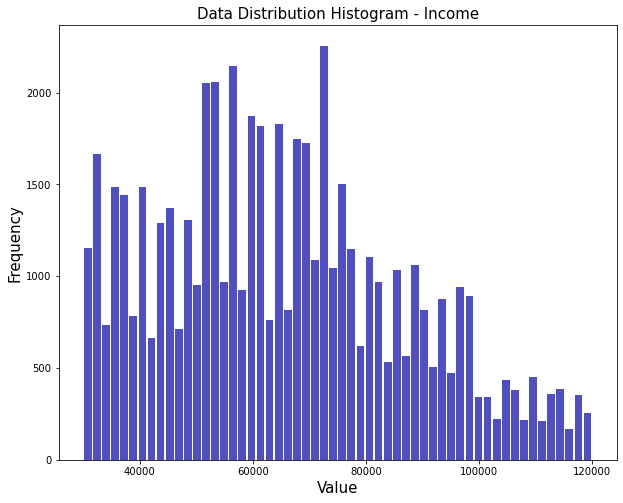

In [94]:
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(x=income_np, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution Histogram - Income',fontsize=15)
plt.show()

This histogram gives us the idea that our dataset lacks records or datapoints of customers who has income between 70,000 and 120,000. It's essentially a distribution which is positively skewed or right skewed. So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance. Hence, we may need to normalize the data afterwards.

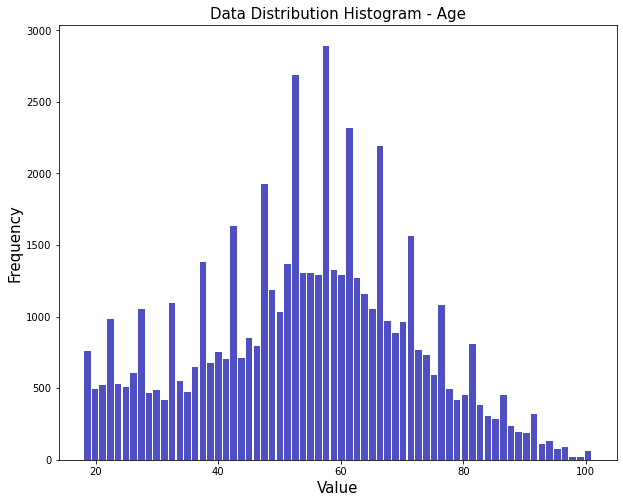

In [95]:
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(x=age_np, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution Histogram - Age',fontsize=15)
plt.show()

The distribution of the variable ‘age’
in the dataset is positively skewed or right skewed. Hence, we may need to standardize
the same.

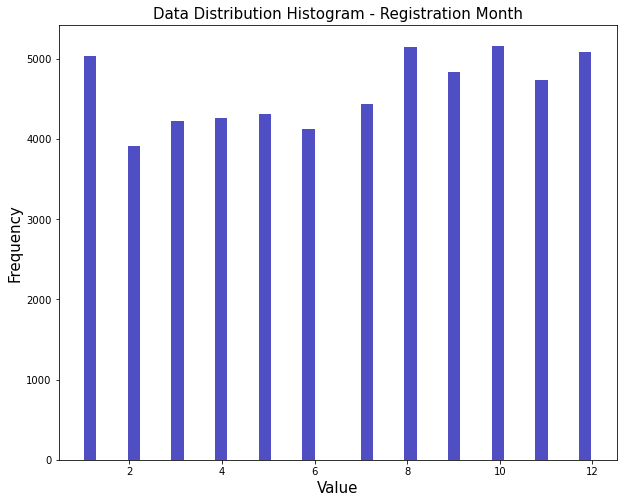

In [96]:
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(x=reg_month_np, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution Histogram - Registration Month',fontsize=15)
plt.show()

As the data distribution cannot be assumed as a gaussian distribution, we
may not standardise the variable but we may normalize it to a normal scale such that there won’t be varying scales in the dataset and the algorithm we are using does not
make assumptions about the distribution of the data.

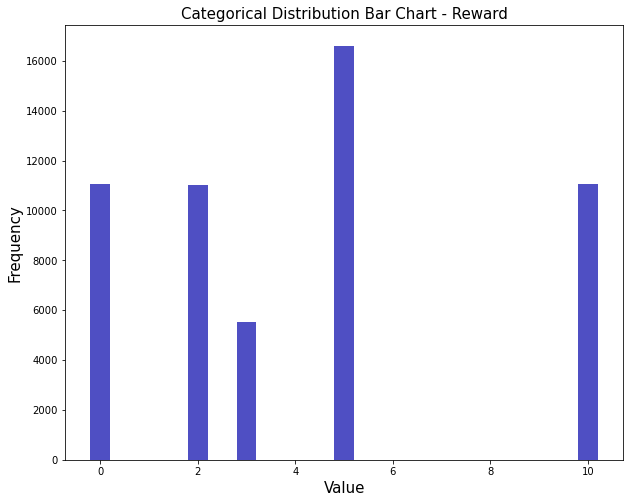

In [97]:
unique_elements, counts_elements = np.unique(reward_np, return_counts=True)

plt.figure(figsize=[10, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution Bar Chart - Reward',fontsize=15)
plt.show()

Normalization is to be done.

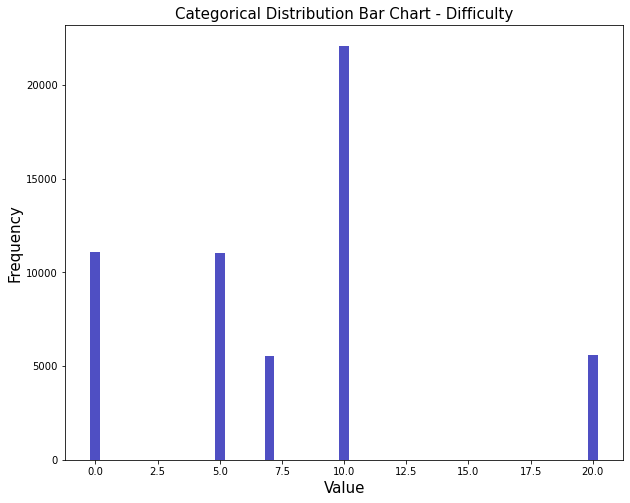

In [98]:
unique_elements, counts_elements = np.unique(difficulty_np, return_counts=True)

plt.figure(figsize=[10, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution Bar Chart - Difficulty',fontsize=15)
plt.show()

Normalization is to be done.

### 2.2. Frequency Table

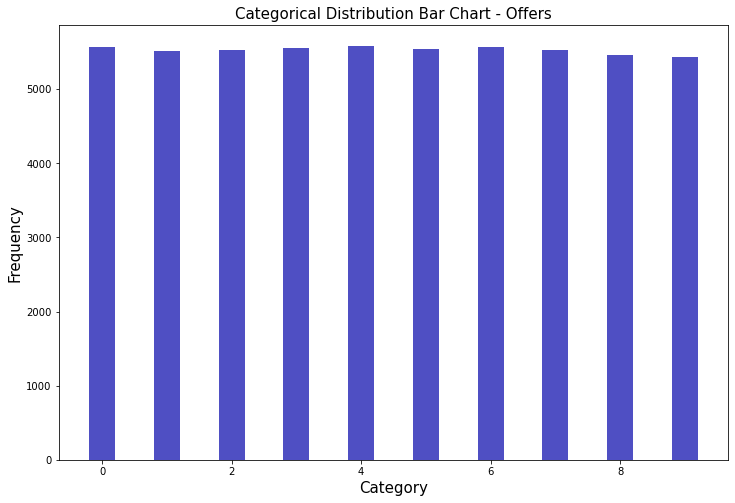

In [99]:
unique_elements, counts_elements = np.unique(offer_id_np, return_counts=True)

plt.figure(figsize=[12, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution Bar Chart - Offers',fontsize=15)
plt.show()

We have a balanced categorical data distribution
for the variable ‘offers’ which can be encoded later using any suitable encoding scheme.

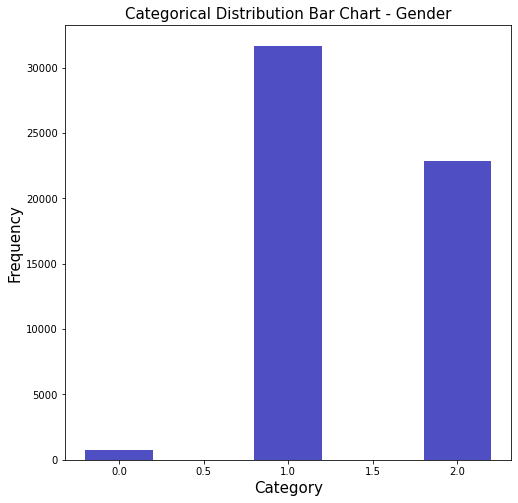

In [100]:
unique_elements, counts_elements = np.unique(gender_np, return_counts=True)

plt.figure(figsize=[8, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution Bar Chart - Gender',fontsize=15)
plt.show()

We have an imbalanced categorical data
distribution for the variable ‘gender’ which can be encoded later using any suitableencoding scheme. The first category (‘other’) is the least occuring and hence, its
influence on the target class can be assumed to be low. Also, just because the variable
has a class imbalance, doesn't necessarily mean it isn't correlated with the target
variable.

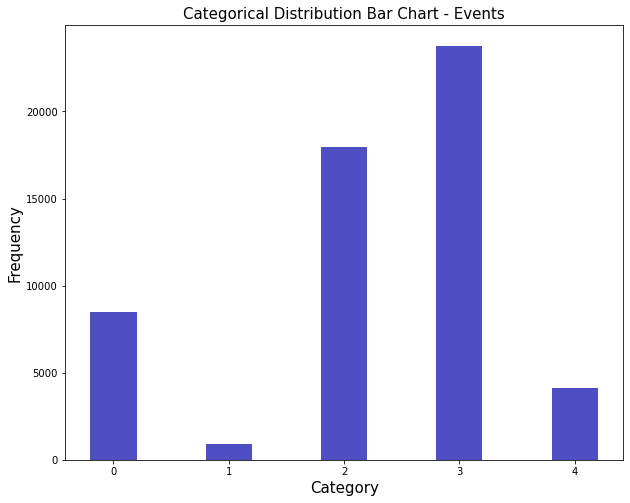

In [101]:
unique_elements, counts_elements = np.unique(event_id_np, return_counts=True)

plt.figure(figsize=[10, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution Bar Chart - Events',fontsize=15)
plt.show()

### Our dataset is imbalanced. The event 'offer viewed' and 'green flag' are the least occuring events compared to the other events. 

## 4. Bi-variate Analysis

Bi-variate Analysis finds out the relationship between two variables. Here, we look for association and disassociation between variables at a pre-defined significance level. We can perform bi-variate analysis for any combination of categorical and continuous variables.

We will be considering the following combination of variables:

1. Age & Income.
2. Offer ID & Registration Month
3. Event ID & Gender

### 4.1. Categorical & Categorical

To find the relationship between two categorical variables

 - Event ID & Gender

In [102]:
event_ids = np.unique(event_id_np)

other_list = np.empty(shape=0, dtype=np.int64)
male_list = np.empty(shape=0, dtype=np.int64)
female_list = np.empty(shape=0, dtype=np.int64)

for i in range(len(event_ids)):
    gender_count = data[data['event_id']==i].gender.value_counts(sort=False)
    
    other_list = np.append(other_list, gender_count[0])
    male_list = np.append(male_list, gender_count[1])
    female_list = np.append(female_list, gender_count[2])

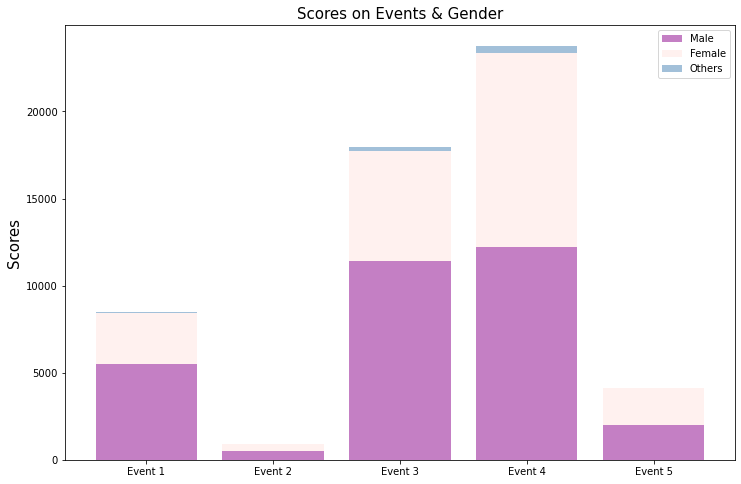

In [103]:
plt.figure(figsize=[12, 8])
p1 = plt.bar(event_ids, male_list, alpha=0.5, color='#8b008b')
p2 = plt.bar(event_ids, female_list, bottom=male_list, alpha=0.5, color='#ffe4e1')
p3 = plt.bar(event_ids, other_list, bottom=male_list+female_list, alpha=0.5, color='#4682b4')
plt.ylabel('Scores', fontsize=15)
plt.title('Scores on Events & Gender', fontsize=15)
plt.legend((p1[0], p2[0], p3[0]), ('Male', 'Female', 'Others'))
plt.xticks(event_ids, ('Event 1', 'Event 2', 'Event 3', 'Event 4', 'Event 5'))
plt.show()

No correlation.

### 4.2. Continuous & Continuous

To find the relationship between two continuous variables.

 - Age & Income

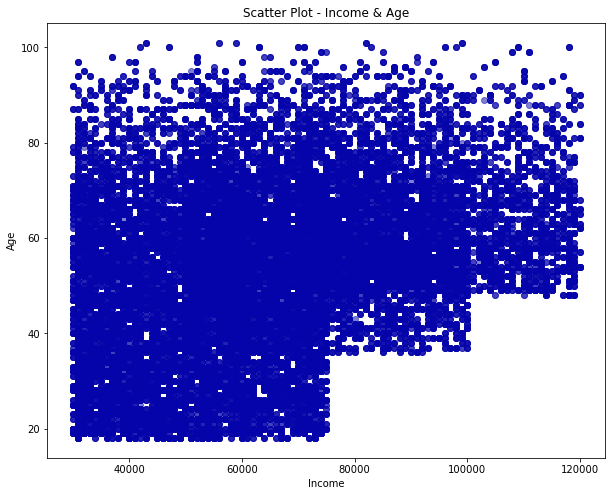

In [104]:
fig = plt.figure(figsize=[10, 8])
plt.scatter(income_np, age_np, color='#0504aa', alpha=0.5)
plt.title('Scatter Plot - Income & Age')
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()

We can observe from the figure that there is a stepwise increase in the income as the age value increases. But we may not be bothered about the same as it’s not a linear correlation.

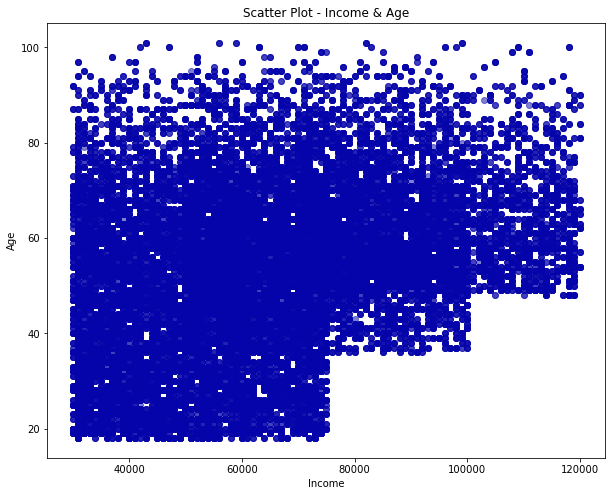

In [105]:
fig = plt.figure(figsize=[10, 8])
plt.scatter(income_np, age_np, color='#0504aa', alpha=0.5)
plt.title('Scatter Plot - Income & Age')
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()

### 4.3. Continuous & Categorical

To find the relationship between a continuous and a catagorical variables.

 - Offer ID & Registration Month

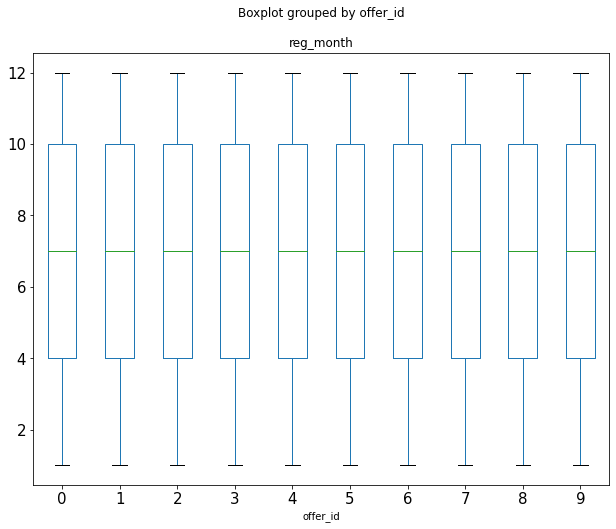

In [106]:
fig, ax = plt.subplots(figsize=[10, 8])
data.boxplot(column='reg_month', by='offer_id', ax=ax, grid=False, fontsize=15)

Correlation among the variables can be inferred from the graph, thus we may try
modeling without and with the variable ‘reg_month’. We can also infer that there are no
outliers.

## 6. Outliers Detection

Let’s use the mathematical function ‘Z-score’ to detect the outliers in the dataset. While
calculating the ‘Z-score’ we re-scale and center the data and look for data points which
are too far from zero. These data points which are way too far from zero will be treated
as the outliers. We have set a threshold of 3 and -3 i.e. if the Z-score value is greater
than or less than 3 or -3 respectively, that data point will be identified as outliers.

In [107]:
from scipy import stats

In [108]:
z_score_data = np.abs(stats.zscore(data))
threshold = 3
print(np.where(z_score_data > 3))

(array([], dtype=int64), array([], dtype=int64))


There aren't any outliers to treat using the mathematical function z-score and from the above visualizations.

## 5. Multi-dimensional Scaling

Multidimensional scaling is a means of visualizing the level of similarity of individual objects of a dataset. It is used to translate information about the pairwise distances among a set of n objects or individuals into a configuration of n points mapped into an abstract Cartesian space. 

We may use this method to scale our dataset dimension into just two components such that the relative distance between the data points are maintained. And then we may scatter plot each class in the dataset into the x-y plane. This may give us a narrow idea about the underlying structure of each class in the dataset.



In [109]:
from sklearn.manifold import MDS

In [110]:
#seperate the inputs and output from the dataset.
target = data['event_id']
predictors = data.drop(['id', 'event_id'], axis=1)

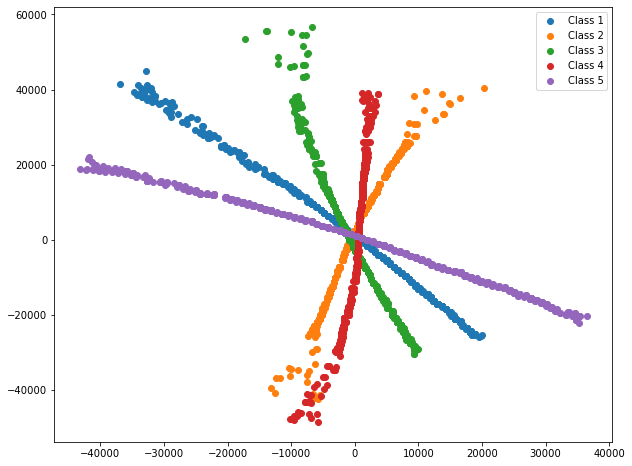

In [111]:
def scatter_plot(event, event_name):
    """To plot records of the passed class or event.
    
    The function perform MDS on the data and scatter plot the same into the 2d space.
    
    Args : 
        
        event (dataframe) - It's the records of the corresponding event.
        event_name (str) - Specifies event name. 
           
    Returns:
        
        None.
        
    """
    sample = event.head(600)
    clf = MDS(n_components=2, n_init=2, max_iter=100, dissimilarity='euclidean')
    X_mds = clf.fit_transform(sample.values)
    cords = X_mds
    scatter = plt.scatter(cords[:, 0], cords[:, 1], label=event_name)  

plt.figure(figsize=[10, 8])

#selecting records corresponding to each event or class and passing it to the function 'scatter_plot'
class_name = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
for i in range(5):
    event = predictors[target==i]
    scatter_plot(event, class_name[i])
    
plt.legend()


From the figure, we can observe that each class in the dataset is separable and is suitable for classification problems. And, from the structure of the data points we can infer that we may need to use a nonlinear function or model to solve the same.


# Feature Engineering

In Feature Engineering we are not going to add any new data, but we are going to make the data that we already have useful.

## 1. Variable Standardization & Normalization

We may use this methods for many reasons such as to scale the data variable, to transform complex non-linear relationships into linear relationships, to normalize skewed distributions etc. 

As we have analyzed in the univariate analysis stage, some of our data variables requires standardization so as to avoid its skewed nature and some requires normalization for scaling down the data.

In [112]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [113]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=111)

In [114]:
std = preprocessing.StandardScaler()
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

norm = preprocessing.MinMaxScaler()
X_train.reward = norm.fit_transform(X_train.reward.values.reshape(-1, 1))
X_train.difficulty = norm.fit_transform(X_train.difficulty.values.reshape(-1, 1))
X_train.reg_month = norm.fit_transform(X_train.reg_month.values.reshape(-1, 1))
X_test.reward = norm.transform(X_test.reward.values.reshape(-1, 1), )
X_test.difficulty = norm.transform(X_test.difficulty.values.reshape(-1, 1))
X_test.reg_month = norm.transform(X_test.reg_month.values.reshape(-1, 1))

In [115]:
#X_train and X_test indexes are out of order so reset the indexes. Otherwise, there will be NaN values in the dataset after encoding.
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

X_train = X_train.drop(['index'], axis=1)
X_test = X_test.drop(['index'], axis=1)

In [116]:
X_test.shape, X_train.shape

((13825, 7), (41473, 7))

# Modeling

We already know that our dataset is imbalanced but we may still try to train and classify on the same dataset and check how rightly the classes are classified. If the minority classes are only misclassified, then we may perform some techniques to balance the dataset and may try to increase the recall of the minority classes and the precision of the majority classes. If the model is not even able to predict the majority classes correctly, then we may keep the dataset as it is but fine tune the model.

As mentioned earlier, since this is a classification problem, the evaluation metric 'accuracy' is not a good choice as accuracy can be a useful measure only if we have the same amount of samples per class but we have an imbalanced set. Other metrics like precision, recall, f1-score are by itself suitable only for binary classification but we could use the same for multiclass classification by the 'one vs all' method, but still it may not work well for an imbalanced dataset. The best metric option available for imbalanced dataset multiclass classification problems are 'confusion matrix', 'macro averaging' and 'micro averaging' of the earlier basic metrics. In 'macro-averaging', we average the performances, e.g., precision or f1-score of each individual class. In 'micro averaging', we calculate the performance, e.g., precision, from the individual true positives, true negatives, false positives, and false negatives of the k-class model. And hence, 'micro averaging' is the best choice to go with.


## 1. DNN (Benchmark Models)
Let's use the DNN model trained and tested on the Starbucks dataset as the
benchmark model. Models built using DNN are considered as the benchmark because it
can perform well on huge datasets and it’s well suited for multiclass classification. As
we already know, DNNs can only accept numerical inputs, so we may have to encode
each categorical input into numerical input. Our dataset has two categorical features:
'gender’ and ‘offer_id’, which are label encoded, i.e. since the variable ‘offer_id’ has 10
categories, each category is denoted by any unique numbers from 0 to 9. The problem
of using label encoding in DNN is that sometimes the model may learn a false relation
between the categories as they are represented in numbers, i.e. when the category -1
represented as 0 is compared to the category-2 represented as 10, since there is a
comparable relation between the numbers 0 and 10, the model may assume that there
is the same relation between the categories 1 and 2, which is obviously misleading.
Thus, label encoding is only recommended when there is a known relationship between
the categories or labels. So now, we have the option to still use the label encoding, or to
use any other encoding schemes like embedding, one hot encoding etc. or to use all the
earlier mentioned schemes and find the respective model performance. Let’s go with
the latter and create a larger space for comparison to our model.

### 1.1. Label Encoded categorical data. 

In [117]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from keras.utils import plot_model
import tensorflow as tf
import keras
import itertools

Using TensorFlow backend.


In [118]:
classes=['offer recieved', 'offer viewed', 'transaction', 'offer completed', 'green flag']

model = Sequential([Dense(32, input_dim=7, activation='relu'),
                    Dropout(0.3),
                    Dense(16, activation='relu'),
                    Dense(5, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=15)

Train on 41473 samples, validate on 13825 samples
Epoch 1/15
41473/41473 [==============================] - 6s 148us/step - loss: 1.1415 - accuracy: 0.5383 - val_loss: 1.0036 - val_accuracy: 0.6190
Epoch 2/15
41473/41473 [==============================] - 6s 140us/step - loss: 1.0015 - accuracy: 0.6051 - val_loss: 0.9680 - val_accuracy: 0.6192
Epoch 3/15
41473/41473 [==============================] - 6s 139us/step - loss: 0.9698 - accuracy: 0.6090 - val_loss: 0.9555 - val_accuracy: 0.6196
Epoch 4/15
41473/41473 [==============================] - 6s 140us/step - loss: 0.9558 - accuracy: 0.6142 - val_loss: 0.9575 - val_accuracy: 0.6100
Epoch 5/15
41473/41473 [==============================] - 6s 138us/step - loss: 0.9474 - accuracy: 0.6172 - val_loss: 0.9459 - val_accuracy: 0.6174
Epoch 6/15
41473/41473 [==============================] - 6s 140us/step - loss: 0.9418 - accuracy: 0.6168 - val_loss: 0.9347 - val_accuracy: 0.6156
Epoch 7/15
41473/41473 [==============================] - 6s 1

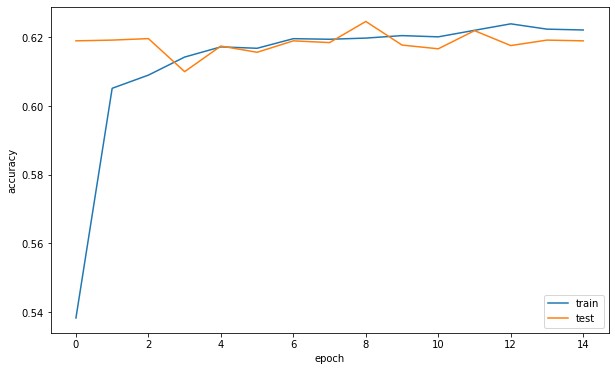

In [119]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

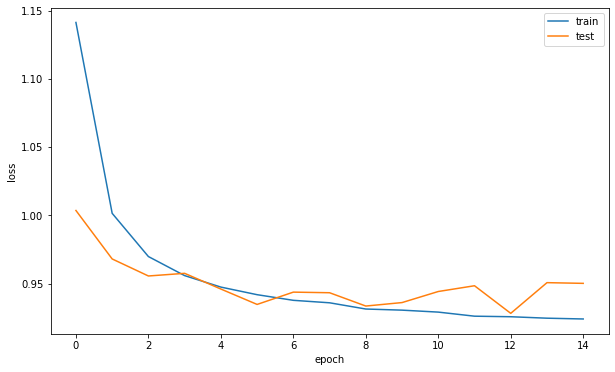

In [120]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [121]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)

In [122]:
print(f1_score(y_test, predicted, average='micro'))

0.6189511754068716


In [123]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


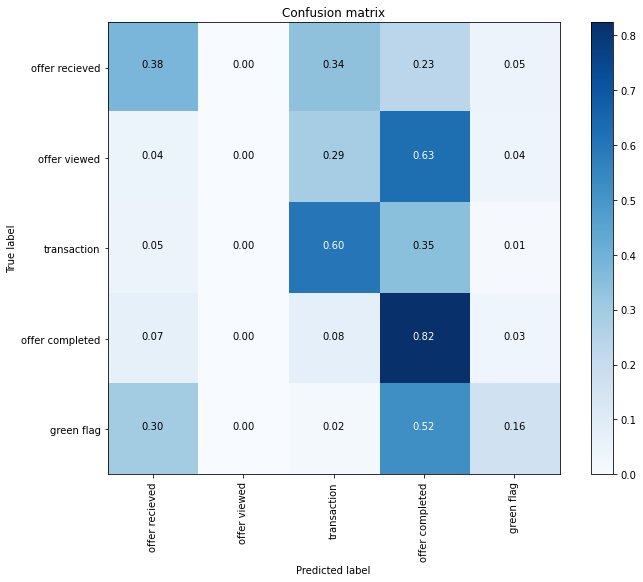

In [124]:
cnf_matrix = confusion_matrix(y_test, predicted)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

#### Majority classes are performing well but the minorities are not.

Problem of imbalanced dataset can be inferred from the confusion matrix. Most of the events are wrongly predicted as 'offer completed'; offer completed is the most occuring event or class.

### 1.2. Embedded categorical data. 

We had encoded the offer_id and gender feature columns earlier itself, but there is a chance that the model could find a false relation between the labels while learing/training, as we had used label encoding (This type of encoding is really only appropriate if there is a known relationship between the categories). One-hot encoding of 'offer_id' won't be a good idea as it could lead to dimensionality explosion. So, let's perform entity embedding on this categorical column.

Since our dataset has both numerical columns and categorical columns, we may build a multi input neural net, one input for each categorical feature, as for the numerical features; all of them will be fed from a single input. 

In [125]:
NUMERICAL_COLUMNS = ['age', 'income', 'reward', 'difficulty', 'reg_month']
CATEGORICAL_COLUMNS = ['offer_id', 'gender']
models = []
inputs = []

numeric_features = X_train[NUMERICAL_COLUMNS]
categorical_features = X_train[CATEGORICAL_COLUMNS]

for cat in categorical_features:
    vocab_size = data[cat].nunique()
    inpt = tf.keras.layers.Input(shape=(1,), name='input_' + '_'.join(cat.split(' ')))
    
    embed = tf.keras.layers.Embedding(vocab_size, 200,trainable=True,\
                                      embeddings_initializer=tf.random_normal_initializer())(inpt)
    embed_rehsaped = tf.keras.layers.Reshape(target_shape=(200,))(embed)
    models.append(embed_rehsaped)
    inputs.append(inpt)
    
num_input = tf.keras.layers.Input(shape=(len(NUMERICAL_COLUMNS)),\
                                  name='input_number_features')
# append this model to the list of models
models.append(num_input)
# keep track of the input, we are going to feed them later to the #final model
inputs.append(num_input)

merge_models = tf.keras.layers.concatenate(models)

In [126]:
pre_preds = tf.keras.layers.Dense(128, activation='relu')(merge_models)
pre_preds = tf.keras.layers.Dense(128, activation='relu')(pre_preds)
pre_preds = tf.keras.layers.Dropout(.2)(pre_preds)
pre_preds = tf.keras.layers.Dense(64, activation='relu')(pre_preds)

pred = tf.keras.layers.Dense(5, activation='softmax')(pre_preds)

model = tf.keras.models.Model(inputs= inputs,\
                                       outputs =pred)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,\
                       metrics=['accuracy'],
                       optimizer='adam')

#Since we have used a multi input neural network, it is best practice to feed your train data as a dictionary, 
#where your keys are the name of the Input layer and the values are what each layer is expected to have.

input_dict = {
    "input_offer_id":X_train["offer_id"],
    "input_gender":X_train["gender"],
    "input_number_features": X_train[NUMERICAL_COLUMNS]
}

input_dict_test = {
    "input_offer_id":X_test["offer_id"],
    "input_gender":X_test["gender"],
    "input_number_features": X_test[NUMERICAL_COLUMNS]
}

history = model.fit(input_dict, y_train, epochs=15, validation_data=(input_dict_test, y_test), batch_size=32)


Train on 41473 samples, validate on 13825 samples
Epoch 1/15
41473/41473 [==============================] - 6s 137us/sample - loss: 0.9447 - accuracy: 0.6154 - val_loss: 0.9234 - val_accuracy: 0.6230
Epoch 2/15
41473/41473 [==============================] - 5s 115us/sample - loss: 0.9209 - accuracy: 0.6245 - val_loss: 0.9179 - val_accuracy: 0.6297
Epoch 3/15
41473/41473 [==============================] - 5s 115us/sample - loss: 0.9168 - accuracy: 0.6276 - val_loss: 0.9136 - val_accuracy: 0.6295
Epoch 4/15
41473/41473 [==============================] - 5s 113us/sample - loss: 0.9135 - accuracy: 0.6273 - val_loss: 0.9138 - val_accuracy: 0.6289
Epoch 5/15
41473/41473 [==============================] - 5s 111us/sample - loss: 0.9116 - accuracy: 0.6277 - val_loss: 0.9146 - val_accuracy: 0.6284
Epoch 6/15
41473/41473 [==============================] - 5s 111us/sample - loss: 0.9092 - accuracy: 0.6304 - val_loss: 0.9118 - val_accuracy: 0.6286
Epoch 7/15
41473/41473 [==========================

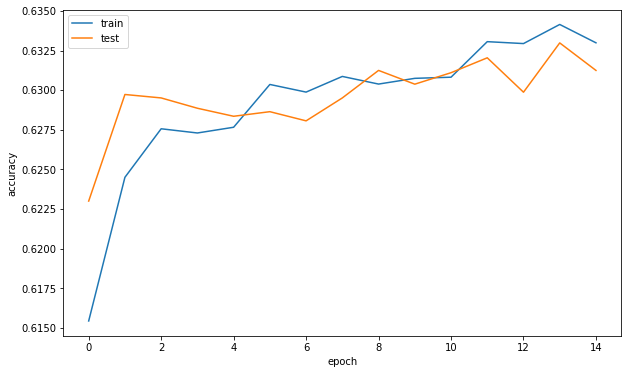

In [127]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

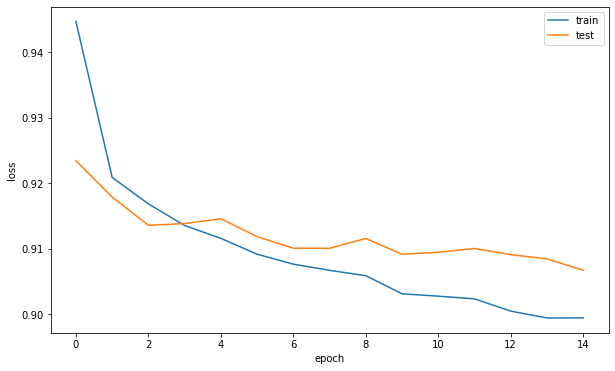

In [128]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [129]:
predicted = model.predict(input_dict_test)
predicted = np.argmax(predicted, axis=1)
print(f1_score(y_test, predicted, average='micro'))

0.63124773960217


Normalized confusion matrix


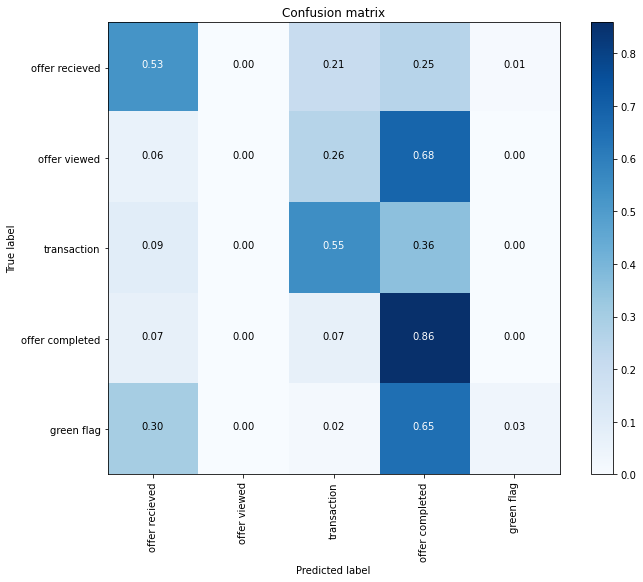

In [130]:
cnf_matrix = confusion_matrix(y_test, predicted)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

Problem of imbalanced dataset can be inferred from the confusion matrix. Most of the events are wrongly predicted as 'offer completed'; offer completed is the most occuring event or class.

### 1.3. One-Hot Encoded categorical data.

In [131]:
enc = preprocessing.OneHotEncoder()
onehot_df_train = enc.fit_transform(X_train.offer_id.values.reshape(-1, 1))
onehot_df_test = enc.transform(X_test.offer_id.values.reshape(-1, 1))

In [132]:
onehot_df_train = onehot_df_train.toarray()
onehot_df_test = onehot_df_test.toarray()

In [133]:
onehot_df_train = pd.DataFrame(onehot_df_train)
onehot_df_test = pd.DataFrame(onehot_df_test)

In [134]:
X_train = pd.concat([X_train, onehot_df_train], axis=1)
X_test = pd.concat([X_test, onehot_df_test], axis=1)

In [135]:
X_train = X_train.drop(['offer_id'], axis=1)
X_test = X_test.drop(['offer_id'], axis=1)

In [136]:
model = Sequential([Dense(8, input_dim=16, activation='relu'),
                    Dense(8, activation='relu'),
                    Dense(5, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

Train on 41473 samples, validate on 13825 samples
Epoch 1/20
41473/41473 [==============================] - 4s 98us/step - loss: 1.0421 - accuracy: 0.5820 - val_loss: 0.9418 - val_accuracy: 0.6162
Epoch 2/20
41473/41473 [==============================] - 4s 93us/step - loss: 0.9291 - accuracy: 0.6172 - val_loss: 0.9353 - val_accuracy: 0.6156
Epoch 3/20
41473/41473 [==============================] - 4s 94us/step - loss: 0.9225 - accuracy: 0.6215 - val_loss: 0.9241 - val_accuracy: 0.6209
Epoch 4/20
41473/41473 [==============================] - 4s 94us/step - loss: 0.9195 - accuracy: 0.6226 - val_loss: 0.9220 - val_accuracy: 0.6236
Epoch 5/20
41473/41473 [==============================] - 4s 94us/step - loss: 0.9181 - accuracy: 0.6240 - val_loss: 0.9243 - val_accuracy: 0.6212
Epoch 6/20
41473/41473 [==============================] - 4s 95us/step - loss: 0.9167 - accuracy: 0.6250 - val_loss: 0.9197 - val_accuracy: 0.6231
Epoch 7/20
41473/41473 [==============================] - 4s 94us/st

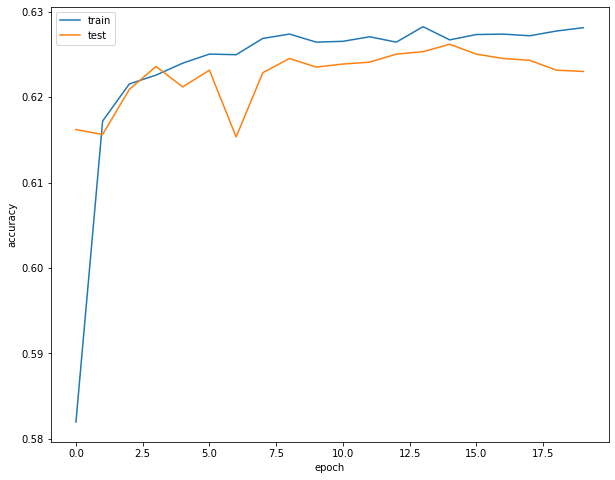

In [137]:
plt.figure(figsize=[10, 8])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

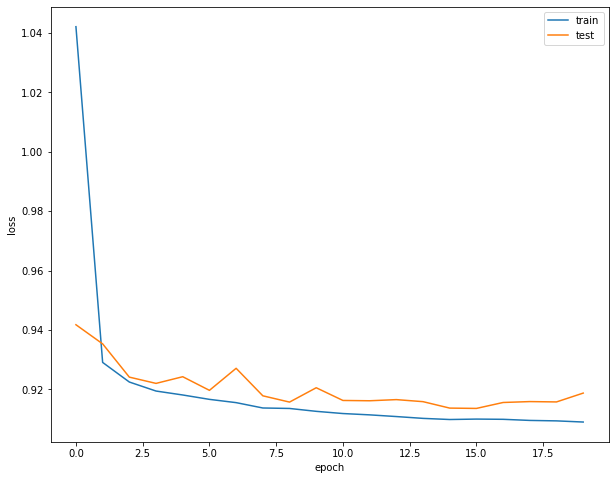

In [138]:
plt.figure(figsize=[10, 8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [139]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
print(f1_score(y_test, predicted, average='micro'))

0.623001808318264


Normalized confusion matrix


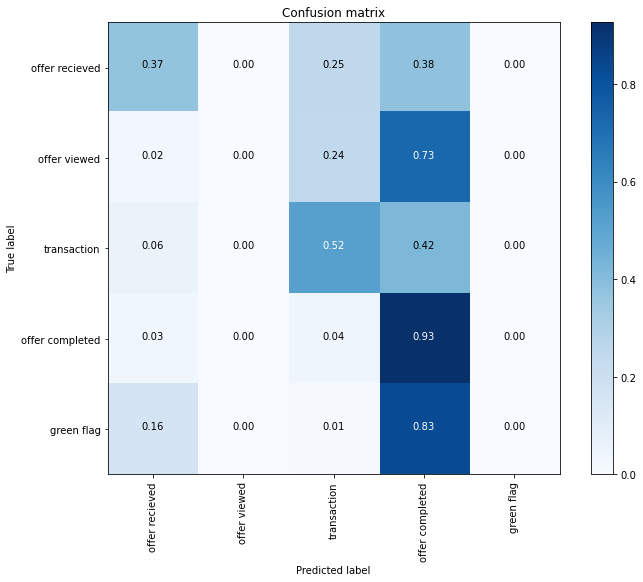

In [140]:
cnf_matrix = confusion_matrix(y_test, predicted)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

Problem of imbalanced dataset can be inferred from the confusion matrix. Most of the events are wrongly predicted as 'offer completed'; offer completed is the most occuring event or class.

As expected, the label encoded model has performed the least. The feature embedded model has performed better than both the label encoded and one hot encoded model. An embedding is actually a mapping of a discrete categorical variable to a vector of continuous numbers. Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables. It can rapidly generate great results on structured data without having to resort to feature engineering or apply domain specific knowledge. 


## 2. XGBoost (Our Model)

Let's use the XGBoost machine learning technique to build our model. One could find it less trivial to implement XGBoost for multiclass classification as it’s not directly implemented to the Python API XGBClassifier. To use XGBoost main module for a multiclass classification problem, it is required to change the value of two parameters: objective and num_class. Features are not normalised as this method is based on decision trees.


In [141]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score
import itertools

In [142]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=111)

In [143]:
#X_train and X_test indexes are out of order so reset the indexes
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

X_train = X_train.drop(['index'], axis=1)
X_test = X_test.drop(['index'], axis=1)

In [144]:
X_train.shape, X_test.shape

((41473, 7), (13825, 7))

In [145]:
params = {  
    'max_depth' : 10,
    'gamma'     : 5,
    'objective' : 'multi:softmax',
    'num_class' : 5,
    'eval_metric' : ["merror", 'mlogloss'],
    'n_gpus' : 0
}

In [146]:
model = xgb.XGBClassifier(**params)

In [147]:
evallist = [(X_train, y_train), (X_test, y_test)]

In [148]:
model.fit(X_train, y_train, eval_set=evallist, eval_metric=["merror", 'mlogloss'], verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['merror', 'mlogloss'], gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_gpus=0, n_jobs=0, num_class=5,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [149]:
predictions = model.predict(X_test)

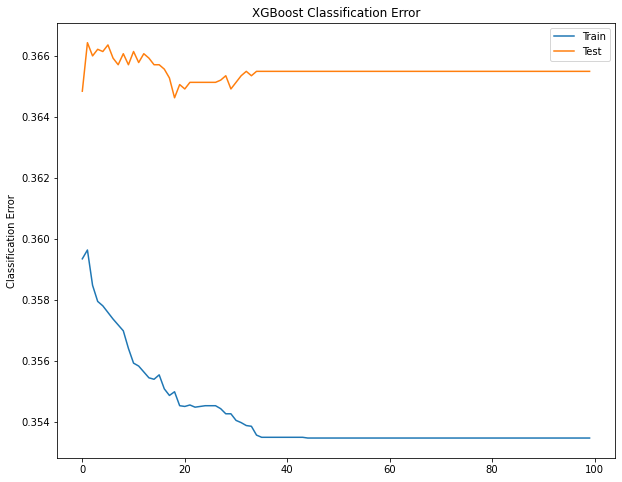

In [150]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['merror'], label = 'Train')
plt.plot(x_axis, results['validation_1']['merror'], label = 'Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

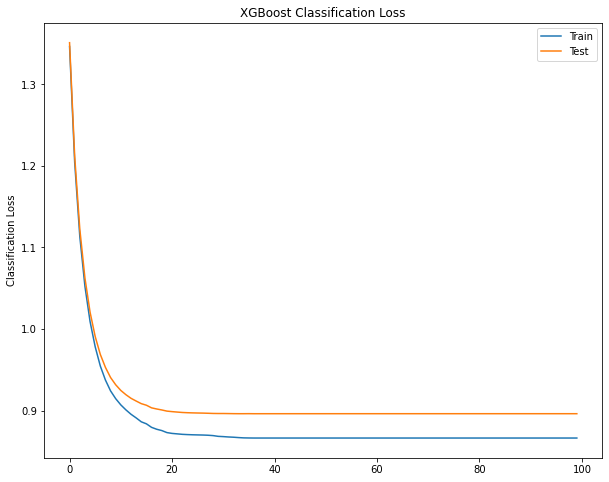

In [151]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['mlogloss'], label = 'Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label = 'Test')
ax.legend()
plt.ylabel('Classification Loss')
plt.title('XGBoost Classification Loss')
plt.show()

In [152]:
print(f1_score(y_test, predictions, average='micro'))

0.634502712477396


Normalized confusion matrix


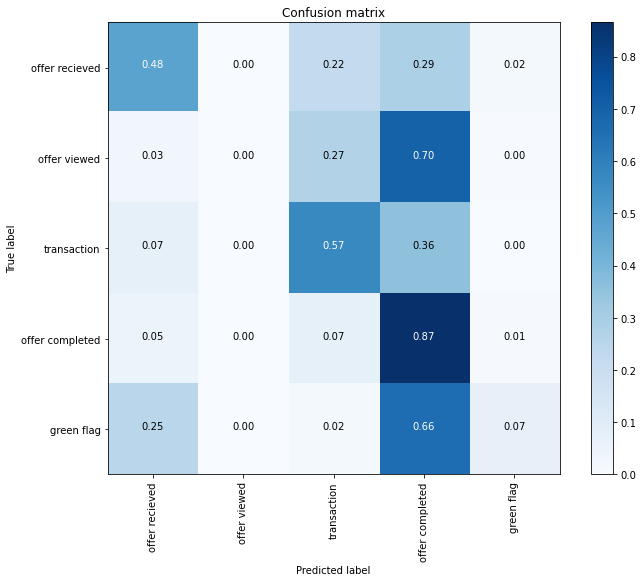

In [153]:
cnf_matrix = confusion_matrix(y_test, predictions)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

From the confusion matrix it's evident that the classes are wrongly classified as our dataset is imbalanced. The least occuring classes, 'offer viewed' and 'green flag' are the ones which are mostly wrongly predicted or classified.

# Handling Imbalanced Dataset

With the imbalanced dataset, we are getting a micro-average f1-score of around 63.45% for the XGB model; In reality this value cannot be taken into consideration for determining the performance of the model as that value would be more representative of the majority class, i.e. the true predictions of the majority classes 'offer received', 'offer transaction' and 'offer completed' are 0.48, 0.57 and 0.87 respectively; where as the true predictions of the minority classes 'offer viewed' and 'green flag' are 0.0 and 0.07 respectively; Thus, if we classify the records from the class 'offer viewed' by just seeing the f1-score of the model, then obviously the model is never going to predict it correct as that class is having a true score of exact zero.


The micro-average f1-score of different models on imbalanced dataset are:

 - DNN (Label Enoded categorical data) &emsp;  &ensp; &nbsp; - 61.89%
 - DNN (Embedded categorical data) &emsp; &emsp; &ensp; &nbsp; - 63.12%
 - DNN (One-Hot Encoded categorical data) &ensp; - 62.30%
 - XGBoost (Non-Normalized) &emsp; &emsp; &emsp; &emsp; &emsp; &ensp; - 63.45%
 
##### From the confusion matrices we can infer that most of the wrong classifications are made from the minority classes. And the majority classes are having higher rate of true predictions. Thus, it's comprehensible that we can get higher true predictions from the same model if we have more datapoints or records for the minority classes. Getting new intended data from the customers would not be a hardship for Starbucks, when we already have a model which can perform well with enough data. But, for the time being we may use imbalanced dataset handling techniques on the dataset to prove that we can get atleast average true predictions for all the classes with just these sampled data.

It's known that the newly sampled data can never represent the original data, hence we aren't expecting to get a greater accuracy or precision but just to check whether an average amount of data can be classified into its true classes; If yes, more data of the minority classes from starbucks in the future can make the model much more accurate; Otherwise, we may have to understand that wrong classification are because the datapoints or records of 'offer viewed' and 'green flag' are so similar such that the model cannot distinguish among them and even new data cannot help the model to perform well.
 
Now, let's treat the imbalanced dataset by using the RandomOverSampler (Random Over-sampling Technique) for over-sampling and see how the confusion matrix changes for the models.

## 1. Random Over-Sampling - XGBoost

Ensure that we apply oversampling technique only on the train set, because oversampling on the dataset may allow the exact same observations to be present in both the test and train sets. This can make our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.
Now, let's treat the imbalanced dataset by using the RandomOverSampler (Random Over-sampling Technique) for over-sampling and see how the confusion matrix changes for the benchmark model and our model.


In [154]:
from imblearn.over_sampling import RandomOverSampler

In [155]:
sm = RandomOverSampler(sampling_strategy='not majority')
X_train, y_train = sm.fit_sample(X_train, y_train)

In [156]:
params = {
    'max_depth' : 14,
    'gamma'     : 5,
    'objective' : 'multi:softmax',
    'num_class' : 5,
    'eval_metric' : ["merror", 'mlogloss'],
    'n_gpus' : 0
}

In [157]:
model = xgb.XGBClassifier(**params)

In [158]:
evallist = [(X_train, y_train), (X_test, y_test)]

In [159]:
model.fit(X_train, y_train, eval_set=evallist, eval_metric=["merror", 'mlogloss'], verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['merror', 'mlogloss'], gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=14,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_gpus=0, n_jobs=0, num_class=5,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [160]:
predictions = model.predict(X_test)

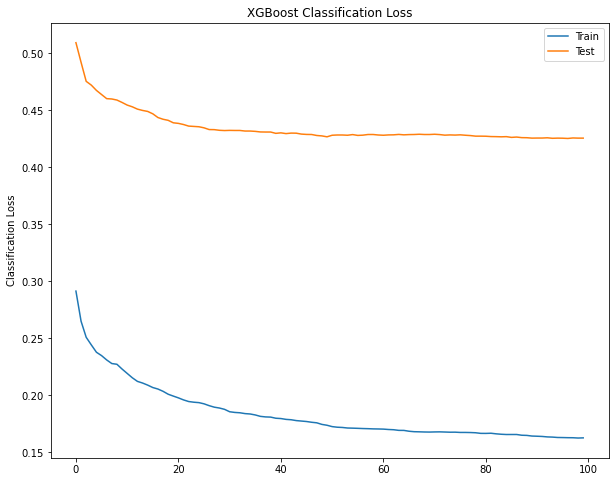

In [161]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['merror'], label = 'Train')
plt.plot(x_axis, results['validation_1']['merror'], label = 'Test')
ax.legend()
plt.ylabel('Classification Loss')
plt.title('XGBoost Classification Loss')
plt.show()

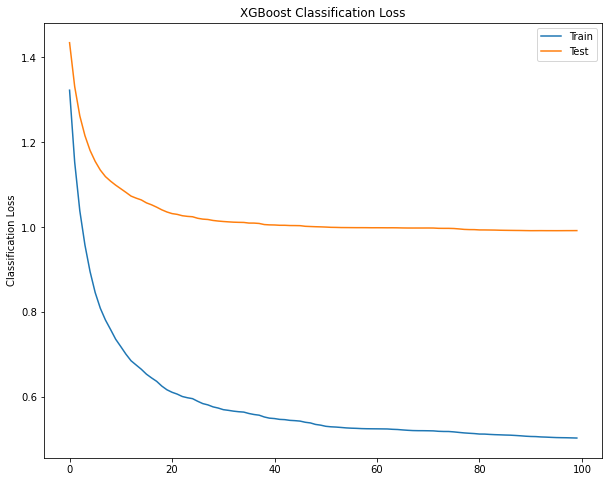

In [162]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['mlogloss'], label = 'Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label = 'Test')
ax.legend()
plt.ylabel('Classification Loss')
plt.title('XGBoost Classification Loss')
plt.show()

In [163]:
print(recall_score(y_test, predictions, average='micro'))

0.5743218806509945


Normalized confusion matrix


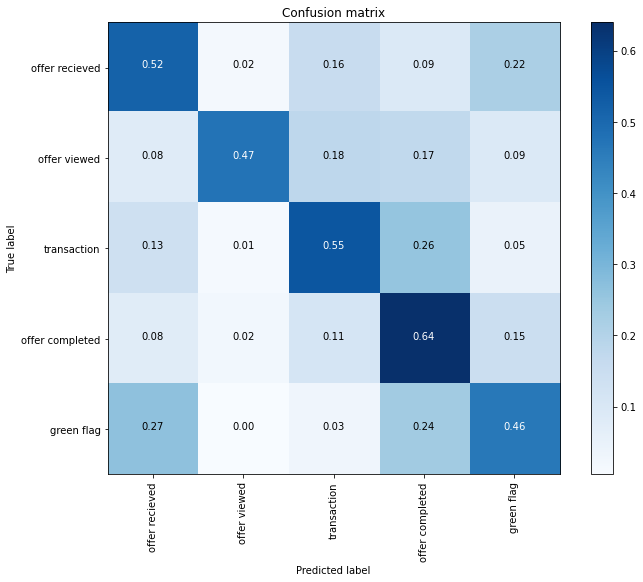

In [164]:
cnf_matrix = confusion_matrix(y_test, predictions)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

###### As we thought, the model is able to classify 50% of all the records from each class correctly. As said earlier, we should not be concerned about the classification score right now, as we already know that the sampled data cannot give much precision as compared to the original data. 

## Random Over-Sampling - DNN

In [165]:
std = preprocessing.StandardScaler()
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_test.income = std.transform(X_test.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))
X_test.age = std.fit_transform(X_test.age.values.reshape(-1, 1))

norm = preprocessing.MinMaxScaler()
X_train.reward = norm.fit_transform(X_train.reward.values.reshape(-1, 1))
X_train.difficulty = norm.fit_transform(X_train.difficulty.values.reshape(-1, 1))
X_train.reg_month = norm.fit_transform(X_train.reg_month.values.reshape(-1, 1))
X_test.reward = norm.transform(X_test.reward.values.reshape(-1, 1), )
X_test.difficulty = norm.transform(X_test.difficulty.values.reshape(-1, 1))
X_test.reg_month = norm.transform(X_test.reg_month.values.reshape(-1, 1))

In [166]:
NUMERICAL_COLUMNS = ['age', 'income', 'reward', 'difficulty', 'reg_month']
CATEGORICAL_COLUMNS = ['offer_id', 'gender']
models = []
inputs = []

numeric_features = X_train[NUMERICAL_COLUMNS]
categorical_features = X_train[CATEGORICAL_COLUMNS]

for cat in categorical_features:
    vocab_size = data[cat].nunique()
    inpt = tf.keras.layers.Input(shape=(1,), name='input_' + '_'.join(cat.split(' ')))
    
    embed = tf.keras.layers.Embedding(vocab_size, 200,trainable=True,\
                                      embeddings_initializer=tf.random_normal_initializer)(inpt)
    embed_rehsaped = tf.keras.layers.Reshape(target_shape=(200,))(embed)
    models.append(embed_rehsaped)
    inputs.append(inpt)
    
num_input = tf.keras.layers.Input(shape=(len(NUMERICAL_COLUMNS)),\
                                  name='input_number_features')
# append this model to the list of models
models.append(num_input)
# keep track of the input, we are going to feed them later to the #final model
inputs.append(num_input)

merge_models = tf.keras.layers.concatenate(models)

In [167]:
pre_preds = tf.keras.layers.Dense(32, activation='relu')(merge_models)
pre_preds = tf.keras.layers.Dense(32, activation='relu')(pre_preds)
pre_preds = tf.keras.layers.Dropout(.2)(pre_preds)
pre_preds = tf.keras.layers.Dense(32, activation='relu')(pre_preds)

pred = tf.keras.layers.Dense(5, activation='softmax')(pre_preds)

model = tf.keras.models.Model(inputs= inputs,\
                                       outputs =pred)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,\
                       metrics=['accuracy'],
                       optimizer='adam')

#Since we have used a multi input neural network, it is best practice to feed your train data as a dictionary, 
#where your keys are the name of the Input layer and the values are what each layer is expected to have.

input_dict= {
    "input_offer_id":X_train["offer_id"],
    "input_gender":X_train["gender"],
    "input_number_features": X_train[NUMERICAL_COLUMNS]
}

input_dict_test= {
    "input_offer_id":X_test["offer_id"],
    "input_gender":X_test["gender"],
    "input_number_features": X_test[NUMERICAL_COLUMNS]
}

history = model.fit(input_dict, y_train, epochs=15, validation_data=(input_dict_test, y_test), batch_size=64)



Train on 89185 samples, validate on 13825 samples
Epoch 1/15
89185/89185 [==============================] - 5s 60us/sample - loss: 1.2602 - accuracy: 0.4568 - val_loss: 1.1954 - val_accuracy: 0.4812
Epoch 2/15
89185/89185 [==============================] - 4s 47us/sample - loss: 1.2155 - accuracy: 0.4717 - val_loss: 1.1903 - val_accuracy: 0.4212
Epoch 3/15
89185/89185 [==============================] - 4s 48us/sample - loss: 1.1997 - accuracy: 0.4757 - val_loss: 1.2072 - val_accuracy: 0.4303
Epoch 4/15
89185/89185 [==============================] - 4s 48us/sample - loss: 1.1911 - accuracy: 0.4802 - val_loss: 1.1958 - val_accuracy: 0.4389
Epoch 5/15
89185/89185 [==============================] - 4s 48us/sample - loss: 1.1836 - accuracy: 0.4846 - val_loss: 1.2039 - val_accuracy: 0.4841
Epoch 6/15
89185/89185 [==============================] - 4s 47us/sample - loss: 1.1788 - accuracy: 0.4909 - val_loss: 1.1788 - val_accuracy: 0.4919
Epoch 7/15
89185/89185 [==============================] 

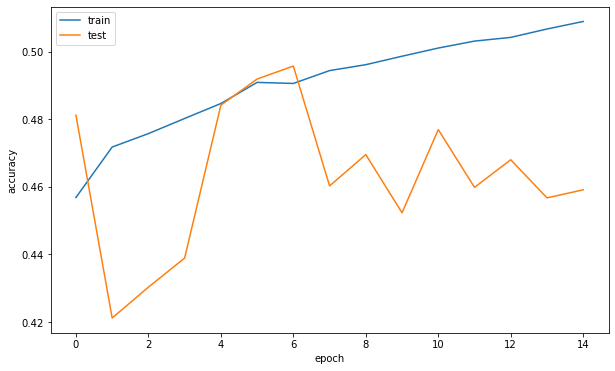

In [168]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

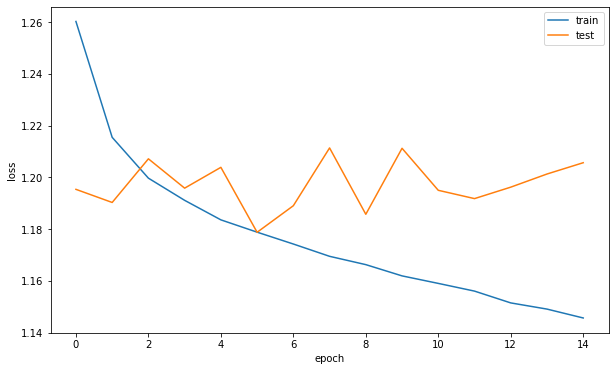

In [169]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [170]:
predicted = model.predict(input_dict_test)
predicted = np.argmax(predicted, axis=1)
print(f1_score(y_test, predicted, average='micro'))

0.45909584086799277


Normalized confusion matrix


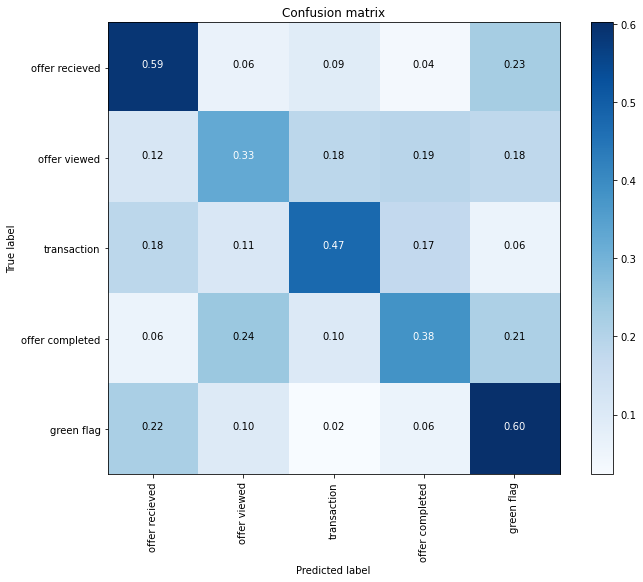

In [171]:
cnf_matrix = confusion_matrix(y_test, predicted)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

## Class Weight Adjustment - DNN


In this method, we may provide a weight for each class which places more emphasis on the minority classes such that the end result is a classifier which can learn equally from all classes. The class weights can be set by assigning a dictionary of class number and its corresponding weights to the argument ‘class_weight’ of fit function provided in keras.


In [172]:
class_weights = {
    0 : 3.2,
    1 : 39.,
    2 : 1.4,
    3 : 1.,
    4 : 6.
}

In [173]:
NUMERICAL_COLUMNS = ['age', 'income', 'reward', 'difficulty', 'reg_month']
CATEGORICAL_COLUMNS = ['offer_id', 'gender']
models = []
inputs = []

numeric_features = X_train[NUMERICAL_COLUMNS]
categorical_features = X_train[CATEGORICAL_COLUMNS]

for cat in categorical_features:
    vocab_size = data[cat].nunique()
    inpt = tf.keras.layers.Input(shape=(1,), name='input_' + '_'.join(cat.split(' ')))
    
    embed = tf.keras.layers.Embedding(vocab_size, 200,trainable=True,\
                                      embeddings_initializer=tf.random_normal_initializer)(inpt)
    embed_rehsaped = tf.keras.layers.Reshape(target_shape=(200,))(embed)
    models.append(embed_rehsaped)
    inputs.append(inpt)
    
num_input = tf.keras.layers.Input(shape=(len(NUMERICAL_COLUMNS)),\
                                  name='input_number_features')
# append this model to the list of models
models.append(num_input)
# keep track of the input, we are going to feed them later to the #final model
inputs.append(num_input)

merge_models = tf.keras.layers.concatenate(models)

In [174]:
pre_preds = tf.keras.layers.Dense(64, activation='relu')(merge_models)
pre_preds = tf.keras.layers.Dense(64, activation='relu')(pre_preds)
pre_preds = tf.keras.layers.Dropout(.2)(pre_preds)
pre_preds = tf.keras.layers.Dense(32, activation='relu')(pre_preds)

pred = tf.keras.layers.Dense(5, activation='softmax')(pre_preds)

model = tf.keras.models.Model(inputs= inputs,\
                                       outputs =pred)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,\
                       metrics=['accuracy'],
                       optimizer='adam')

#Since we have used a multi input neural network, it is best practice to feed your train data as a dictionary, 
#where your keys are the name of the Input layer and the values are what each layer is expected to have.

input_dict= {
    "input_offer_id":X_train["offer_id"],
    "input_gender":X_train["gender"],
    "input_number_features": X_train[NUMERICAL_COLUMNS]
}

input_dict_test= {
    "input_offer_id":X_test["offer_id"],
    "input_gender":X_test["gender"],
    "input_number_features": X_test[NUMERICAL_COLUMNS]
}

history = model.fit(input_dict, y_train, epochs=15, validation_data=(input_dict_test, y_test), batch_size=32, class_weight=class_weights)


Train on 89185 samples, validate on 13825 samples
Epoch 1/15
89185/89185 [==============================] - 10s 109us/sample - loss: 6.2904 - accuracy: 0.2855 - val_loss: 4.6849 - val_accuracy: 0.0744
Epoch 2/15
89185/89185 [==============================] - 9s 99us/sample - loss: 5.7369 - accuracy: 0.3218 - val_loss: 4.5045 - val_accuracy: 0.0976
Epoch 3/15
89185/89185 [==============================] - 9s 98us/sample - loss: 5.5080 - accuracy: 0.3404 - val_loss: 4.5335 - val_accuracy: 0.1009
Epoch 4/15
89185/89185 [==============================] - 9s 98us/sample - loss: 5.3389 - accuracy: 0.3548 - val_loss: 4.5622 - val_accuracy: 0.1189
Epoch 5/15
89185/89185 [==============================] - 9s 97us/sample - loss: 5.2158 - accuracy: 0.3619 - val_loss: 4.3557 - val_accuracy: 0.1486
Epoch 6/15
89185/89185 [==============================] - 9s 98us/sample - loss: 5.1077 - accuracy: 0.3725 - val_loss: 4.4162 - val_accuracy: 0.1279
Epoch 7/15
89185/89185 [==============================

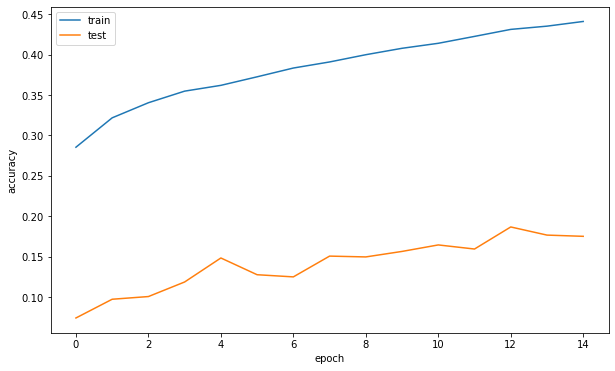

In [175]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

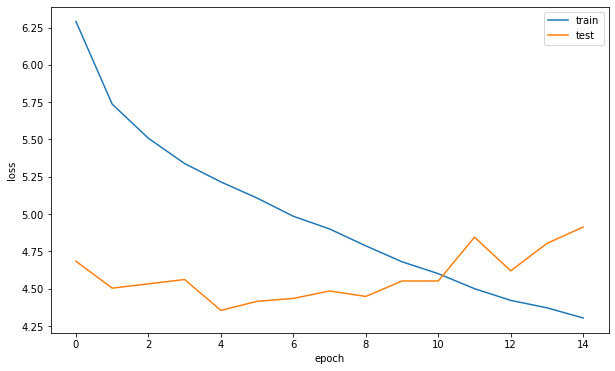

In [176]:
plt.figure(figsize=[10, 6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [177]:
predicted = model.predict(input_dict_test)
predicted = np.argmax(predicted, axis=1)
print(f1_score(y_test, predicted, average='micro'))

0.17533453887884268


Normalized confusion matrix


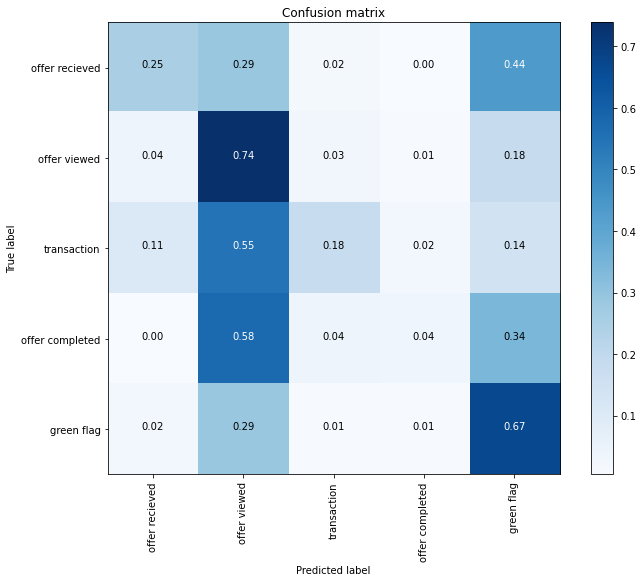

In [178]:
cnf_matrix = confusion_matrix(y_test, predicted)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

## Random Forest for Imbalanced Classification


In [179]:
from sklearn.ensemble import RandomForestClassifier

In [180]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=111)

In [181]:
X_train = X_train.drop(['offer_id'], axis=1)
X_test = X_test.drop(['offer_id'], axis=1)

In [182]:
model = RandomForestClassifier(n_estimators=150, class_weight='balanced_subsample')
history = model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [183]:
print(f1_score(y_test, prediction, average='micro'))

0.553128390596745


Normalized confusion matrix


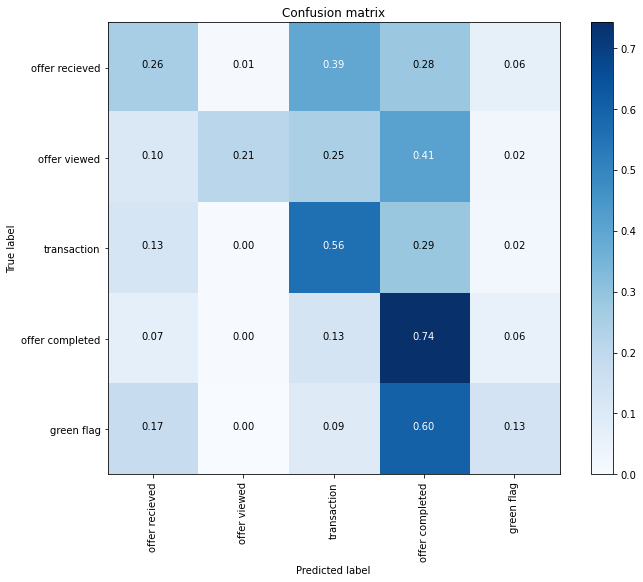

In [184]:
cnf_matrix = confusion_matrix(y_test, prediction)

# Plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes), normalize=True)

## 2. K-Fold Cross-Validation

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model. We may use the Stratified-K-Fold cross-validation method to test the effectiveness of our XGBoost model. Stratified-K-fold is best suited for imbalanced dataset classification so as in our case. It returns stratified folds, i.e while making the folds it maintains the percentage of samples for each class in every fold. So that model gets equally distributed data for training/test folds. I have set the parameter ‘K’ to 10 i.e. we may split the dataset into 10 parts or folds. Each time on the loop we may consider a single fold for testing and rest for training, non-repeatedly. We may evaluate the model on micro-average f1-score each time on the respective test set and all the scores are averaged to obtain a more comprehensive model validation score.


In [185]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import StratifiedKFold

In [186]:
predictors_temp = predictors
predictors_temp = np.array(predictors_temp)
target_temp = target
target_temp = np.array(target_temp)
validation_scores = list()

In [202]:
 params = {
    
    'max_depth' : 10,
    'gamma'     : 5,
    'objective' : 'multi:softmax',
    'num_class' : 5,
    'eval_metric' : ["merror", 'mlogloss'],
    'n_gpus' : 0,
    'n_estimators' : 100
     
          }
    
def create_and_validate_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(**params)
    evallist = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evallist, eval_metric=["merror", 'mlogloss'], verbose=False)
    predictions = model.predict(X_test)
    validation_scores.append(f1_score(y_test, predictions, average='micro'))
    return model
    

In [203]:
skfold = StratifiedKFold(n_splits=10, random_state=111)
for train_index, test_index in skfold.split(predictors_temp, target_temp):
    X_train, X_test = predictors_temp[train_index], predictors_temp[test_index]
    y_train, y_test = target_temp[train_index], target_temp[test_index]
    model = create_and_validate_model(X_train, y_train, X_test, y_test)
    

In [204]:
print(validation_scores)
print(np.mean(validation_scores))

[0.6327305605786618, 0.623508137432188, 0.6479204339963833, 0.6370705244122966, 0.6291139240506329, 0.6443037974683544, 0.640506329113924, 0.638878842676311, 0.6400795803942847, 0.6288659793814433, 0.6327305605786618, 0.623508137432188, 0.6479204339963833, 0.6370705244122966, 0.6291139240506329, 0.6443037974683544, 0.640506329113924, 0.638878842676311, 0.6400795803942847, 0.6288659793814433]
0.6362978109504479


Average validation score after cross-validation is 63.62, which is quite impressive as our
model is having a similar micro-average f1-score of 63.45. And, from the validation
score of each model, we can infer that there is much less variance among them, which’s
a positive indication. A good model is not the one that gives accurate predictions on the
known data or training data but the one which gives good predictions on the new data
and avoids overfitting and underfitting. Thus, we may possibly consider our model as a
good model. (Keeping the problems due to the imbalanced dataset aside.)

## 3. SHAP

The SHAP allows us to show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target. We may use the Tree Explainer function available in SHAP for interpreting our XGBoost machine learning model. Since our’s is a multi-class classification model, we have to show the model’s multiple outputs for a single observation. This means we may have 5 plots (since we have 5 classes) to look at instead of just one (as in the case of binary classification and regression problems). This is useful because we could know why the model made a decision as they are in and why it didn't make another. 


### 3.1 Force Plot

In [205]:
import shap

In [206]:
#attempt to use SHAP on multi-class
X_rand = predictors.sample(1, random_state=42)
idx = X_rand.index.values[0]

In [207]:
X_rand

,offer_id,gender,age,income,reward,difficulty,reg_month
48087,5,1.0,41,57000.0,3.0,7.0,7


In [208]:
print(target[X_rand.index])

48087    2
Name: event_id, dtype: int64


In [209]:
#define the explainer and find force plot for each class on the same sample
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(predictors.iloc[idx])
shap.initjs()
for which_class in range(0,5):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))

###  3.2 Variable Importance Plot

A summary plot with plot type equal to bar or variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power. Since our’s is a multi-class classification model, we have stacked bars for each feature.


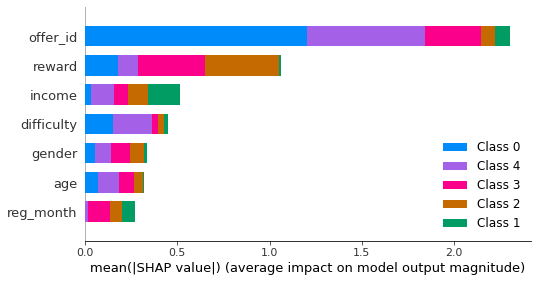

In [210]:
shap_values = shap.TreeExplainer(model).shap_values(X_rand)
shap.summary_plot(shap_values, X_rand)

we can observe that the variable ‘offer_id’ is influencing the model
the most; whereas the variable ‘reg_month’ is influencing the model the least. And also,
we can infer the stacked bars which indicate the predictive power of each feature on
each class. The variable offer_id has a greater impact on the target ‘Class 0’, whereas it
has least impact on the target ‘Class 1’. It’s strange to see that the variable ‘income’
doesn't have any influence on the target ‘Class 0’.

## 2. Dropping Least Occuring Classes 

We have seen how model perform on the imbalanced data and balanced data through sampling. Let's try another way of understanding how well the model performs; Let's try classifying the majority classes only by dropping the minority classes. We expect a greater classification score than that of random over-sampled XGBoost model, as we don't have any sampled data anymore.

In [211]:
filter_1 = data['event_id'] != 1
filter_2 = data['event_id'] != 4

data_after_filter = data.where(filter_1 & filter_2, axis=0)
data_after_filter.dropna(inplace=True)
data_after_filter.reset_index(inplace=True)
target_filtered = data_after_filter['event_id']
predictor_filtered = data_after_filter.drop(['index', 'event_id', 'id'], axis=1)

In [212]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(predictor_filtered, target_filtered, test_size=.25)

In [213]:
params = {
    
    'max_depth' : 5,
    'objective' : 'multi:softmax',
    'num_class' : 3,
    'eval_metric' : ["merror", 'mlogloss'],
    'n_gpus' : 0,
    'n_estimators' : 60
}

In [214]:
model = xgb.XGBClassifier(**params)

In [215]:
evallist = [(X_train_filtered, y_train_filtered), (X_test_filtered, y_test_filtered)]

In [216]:
model.fit(X_train_filtered, y_train_filtered, eval_set=evallist, eval_metric=["merror", 'mlogloss'], verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=60, n_gpus=0, n_jobs=0, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [217]:
predictions = model.predict(X_test_filtered)

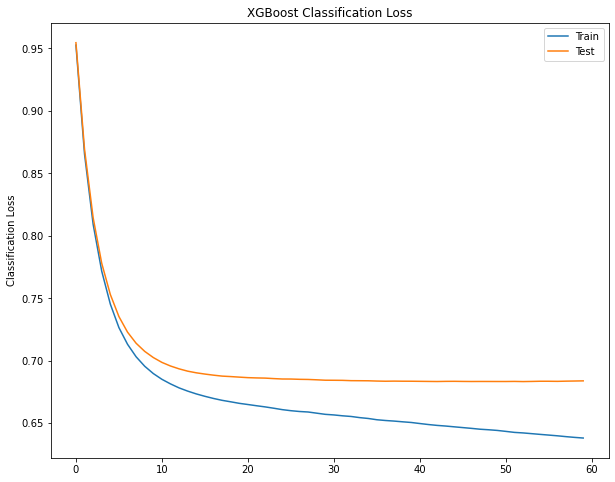

In [218]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['mlogloss'], label = 'Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label = 'Test')
ax.legend()
plt.ylabel('Classification Loss')
plt.title('XGBoost Classification Loss')
plt.show()

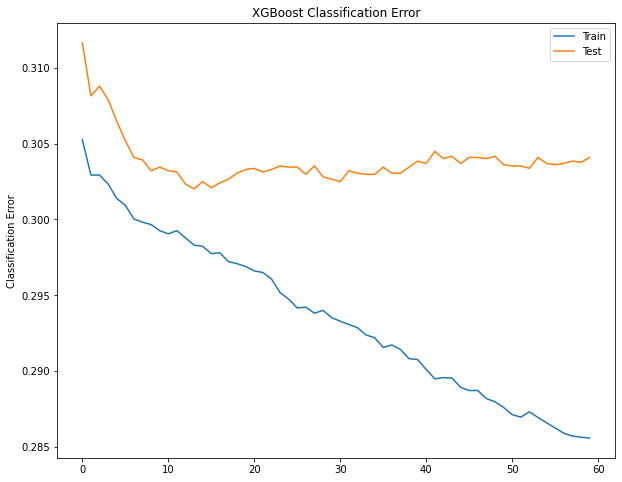

In [219]:
# retrieve performance metrics
results = model.evals_result_
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(x_axis, results['validation_0']['merror'], label = 'Train')
plt.plot(x_axis, results['validation_1']['merror'], label = 'Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [220]:
print(f1_score(y_test_filtered, predictions, average='micro'))

0.6959152798789713


In [221]:
print(classification_report(y_test_filtered, predictions))

              precision    recall  f1-score   support

         0.0       0.61      0.48      0.53      2148
         2.0       0.74      0.56      0.64      4477
         3.0       0.69      0.88      0.78      5934

    accuracy                           0.70     12559
   macro avg       0.68      0.64      0.65     12559
weighted avg       0.70      0.70      0.69     12559



Normalized confusion matrix


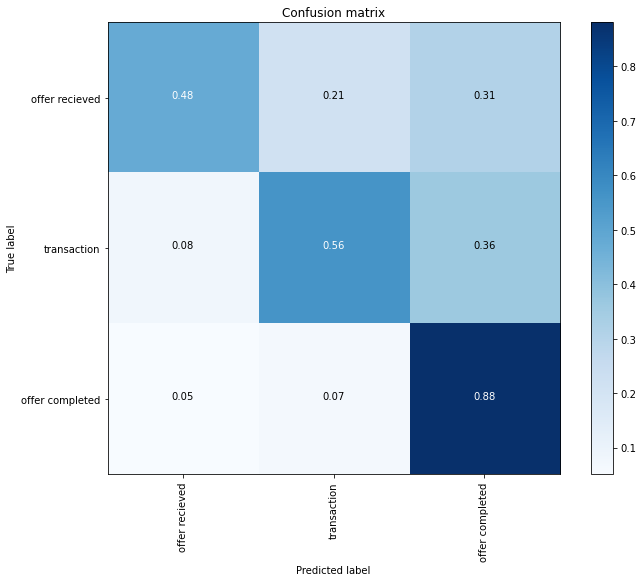

In [222]:
classes_filtered = ['offer recieved', 'transaction', 'offer completed']

cnf_matrix = confusion_matrix(y_test_filtered, predictions)

#plot normalized confusion matrix
fig = plt.figure(figsize=[10, 8])
plot_confusion_matrix(cnf_matrix, classes=np.asarray(classes_filtered), normalize=True)

As mentioned earlier, we weren't expecting to get a greater accuracy, recall or precision for the model (As we’re using imbalanced dataset) but we were to check whether an average amount of data can be classified into its true classes; since now we know it's possible, more data of the minority classes from starbucks in the future can make the model perform much more accurately. Otherwise, we have to understand that the wrong classifications are because the data points or records of each class are so similar that the model is not able to distinguish among them and even a new set of data records cannot make the model perform well. To our expectation, we were able to prove that half the amount of records from each class are classified correctly. And, using our model evaluation framework, we made it clear that a higher accuracy is possible in the future with enough data. (The majority class was classified with a recall of 88%) 

# Conclusion
Problem of imbalanced dataset can be inferred from the confusion matrices of the benchmark models 1
to 3 and our Model, that is, all the minority classes are wrongly predicted as
'offer completed', which is the most occuring event or majority class. In
essence, it is possibly because the models have over learned the majority class and
they aren't anymore able to predict the minority classes. This problem is handled in Model 4
to Model 6 using imbalanced dataset handling techniques. The smooth growth in learning curve and abrupt or no growth in validation curve of Model 4 indicates that the test set is not a representative of the oversampled data. At the same time, the confusion matrix of the Model 5 built using XGBoost on the same oversampled data indicates that 50% of the records from each class are correctly
classified and is working well as expected. From the confusion matrix of Model 6, we can infer that the
model has done pretty well when compared to Model 4 but not as good as Model 5 where class ‘offer viewed’, which is having the least number of data points of all is not predicted at all, which is possibly
because the data points are so little that even the class weight adjustment couldn't prioratize it. The Model 7 is essentially an evaluation framework where we have dropped the minority classes and have made the model to learn and validate on the
majority class alone. Hence why the model witnessed an increase in micro-average f1-score
compared to all other models, even after new dataset being imbalanced again.


# End

If you get to takeaway any information from this notebook, please **UPVOTE** the notebook. It keeps me motivated. Thank you!